# Analysis of the coding mutations

Created: **17/07/18**  
Last modified: **03/08/18**

**Goal:** further analysis on the cleaned dataset `cleaned_IMPACT_mutations_180508.txt`, enriched with the annotations from the `add_features()` function obtained at the end of `annotate_cleaned_dataset.ipynb`. The `synonymous_SNV` are excluded from this study, which only focus on the coding mutations.  
This notebook is divided in two parts:
* **1. The `class` feature: somatic vs non-somatic**: introduce a new feature to class the coding mutations as somatic or non-somatic, and compare these two classes (frequency_in_normals, vaf, strand bias, Kaviar_AF, cosmic count).  
* **2. The `mut_key` feature: study of reccurent mutations**: study the reccurence of coding mutations and the inconsistent `class` classification.

**Refs:**
* [CodingDistributions.Rmd [Elsa]](
https://github.com/ElsaB/impact-annotator/blob/master/analysis/description/180510_elsa/CodingDistributions.Rmd)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-class-feature:-somatic-vs-non-somatic" data-toc-modified-id="The-class-feature:-somatic-vs-non-somatic-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>class</code> feature: somatic vs non-somatic</a></span><ul class="toc-item"><li><span><a href="#Creating-the-feature" data-toc-modified-id="Creating-the-feature-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the feature</a></span></li><li><span><a href="#Comparison-of-the-frequency_in_normals" data-toc-modified-id="Comparison-of-the-frequency_in_normals-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of the <code>frequency_in_normals</code></a></span></li><li><span><a href="#Comparison-of-the-t_vaf" data-toc-modified-id="Comparison-of-the-t_vaf-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparison of the <code>t_vaf</code></a></span></li><li><span><a href="#Comparison-of-the-strand-bias" data-toc-modified-id="Comparison-of-the-strand-bias-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Comparison of the strand bias</a></span></li><li><span><a href="#strand_ratio-vs-t_vaf" data-toc-modified-id="strand_ratio-vs-t_vaf-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span><code>strand_ratio</code> vs <code>t_vaf</code></a></span></li><li><span><a href="#Comparison-of-Kaviar_AF" data-toc-modified-id="Comparison-of-Kaviar_AF-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Comparison of <code>Kaviar_AF</code></a></span></li><li><span><a href="#Comparison-of-cosmic_count" data-toc-modified-id="Comparison-of-cosmic_count-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Comparison of <code>cosmic_count</code></a></span></li></ul></li><li><span><a href="#The-mut_key-feature:-study-of-reccurent-mutations" data-toc-modified-id="The-mut_key-feature:-study-of-reccurent-mutations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The <code>mut_key</code> feature: study of reccurent mutations</a></span><ul class="toc-item"><li><span><a href="#Identify-the-reccurent-mutations" data-toc-modified-id="Identify-the-reccurent-mutations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify the reccurent mutations</a></span></li><li><span><a href="#Sudy-the-reccurent-mutations-genes" data-toc-modified-id="Sudy-the-reccurent-mutations-genes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sudy the reccurent mutations genes</a></span></li><li><span><a href="#Study-of-the-proportion-of-inconsistent-features" data-toc-modified-id="Study-of-the-proportion-of-inconsistent-features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Study of the proportion of inconsistent features</a></span></li></ul></li></ul></div>

***

In [110]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [65]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE)

The `synonymous_SNV` are excluded from this study, which focus only on the coding mutations.

In [66]:
impact <- impact[impact$Consequence != "synonymous_SNV",] # remove the synonymous mutations

nrow(impact[impact$confidence_class == "UNKNOWN",])
impact <- impact[impact$confidence_class != "UNKNOWN",] # keep only the curated mutation (remove 29 rows)

nrow(impact)

[1] 29

[1] 198311

## The `class` feature: somatic vs non-somatic

### Creating the feature

We create a new feature `class`:
* A mutation has `class = somatic` if `confidence_class = AUTO_OK | MANUAL_OK`
* A mutation has `class = non-somatic` if `confidence_class = UNLIKELY | OK_NOT_SO` (it is either a germline or an artefact)

In [67]:
impact$class <- "non-somatic"
impact$class[impact$confidence_class == "AUTO_OK" | impact$confidence_class == "MANUAL_OK"] <- "somatic"
addmargins(table(impact$class, impact$confidence_class), margin = 2)
100 * nrow(impact[impact$class == "non-somatic",]) / nrow(impact) # percentage of non-somatic mutations

,AUTO_OK,MANUAL_OK,OK_NOT_SO,UNLIKELY,Sum
non-somatic,0,0,345,10868,11213
somatic,180763,6335,0,0,187098


[1] 5.65425

The dataset is highly unbalanced with 11,213 non-somatic mutations ($5.7\%$ of the samples) vs 187,098 somatic mutations ($94.3\%$ of the samples).

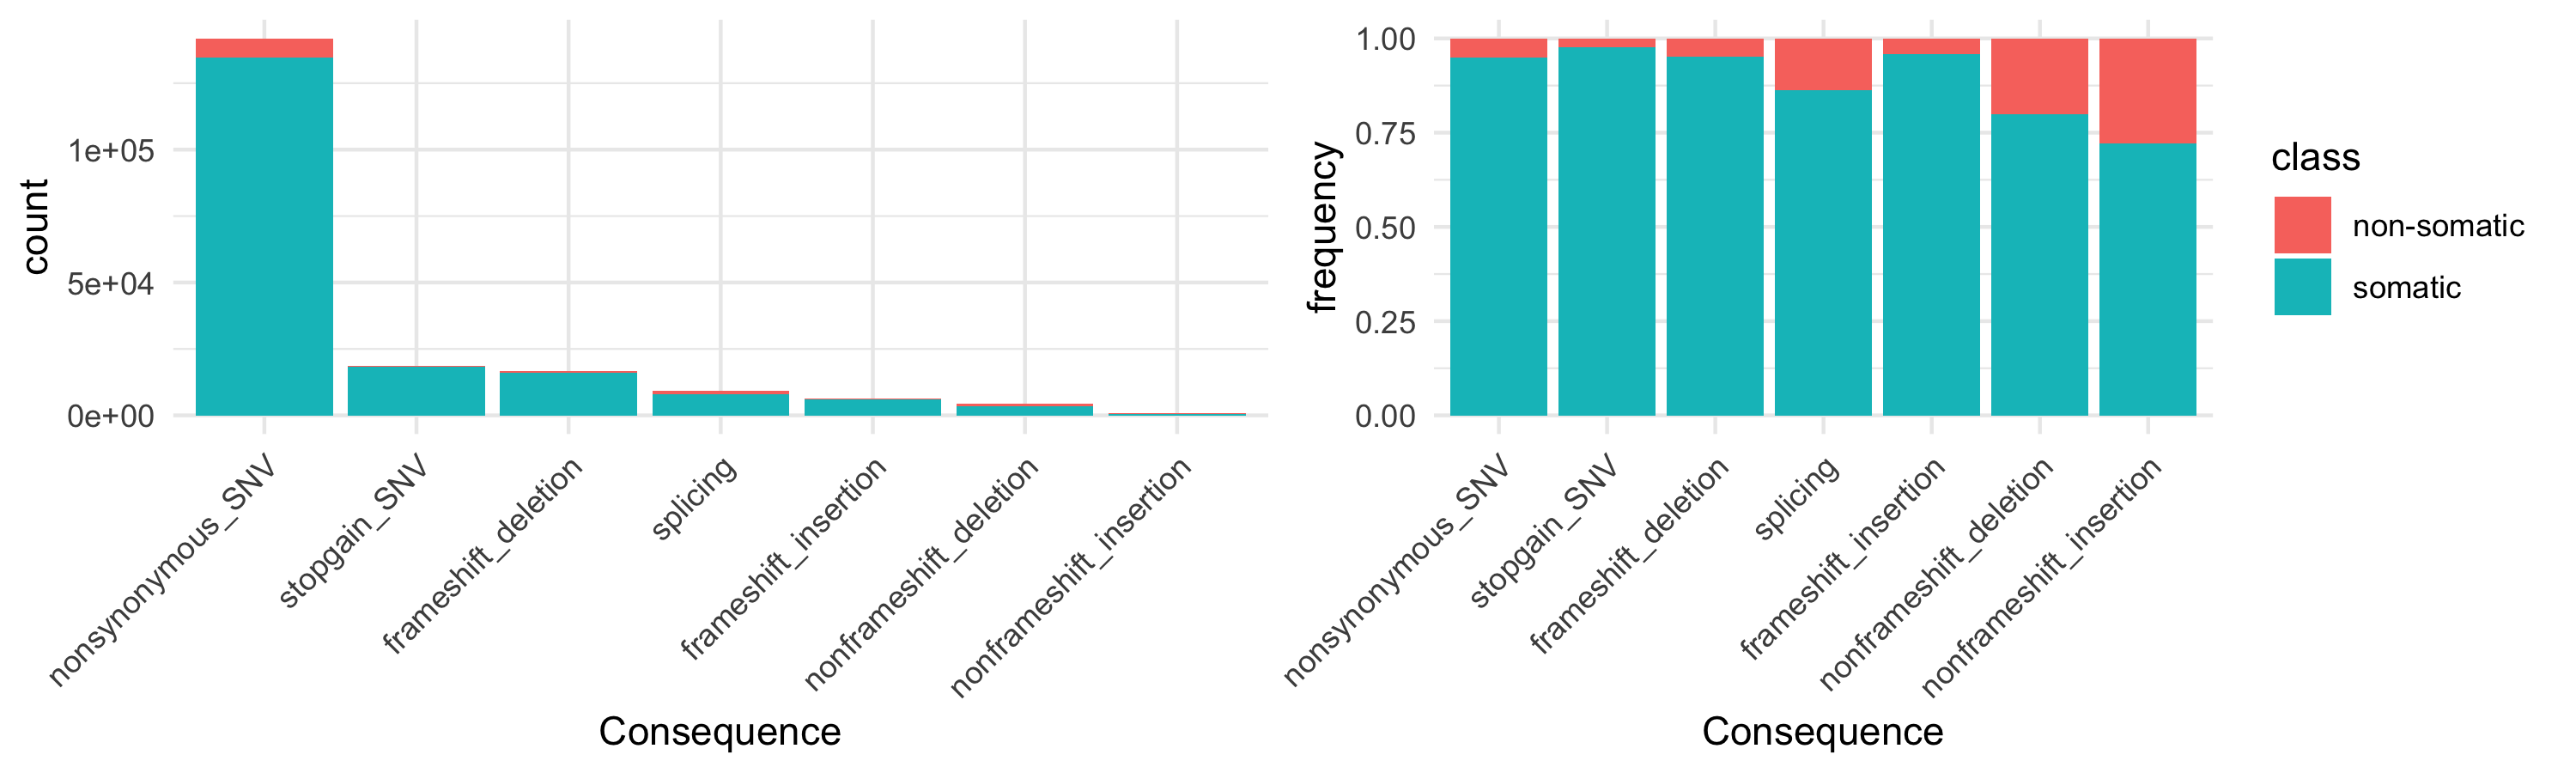

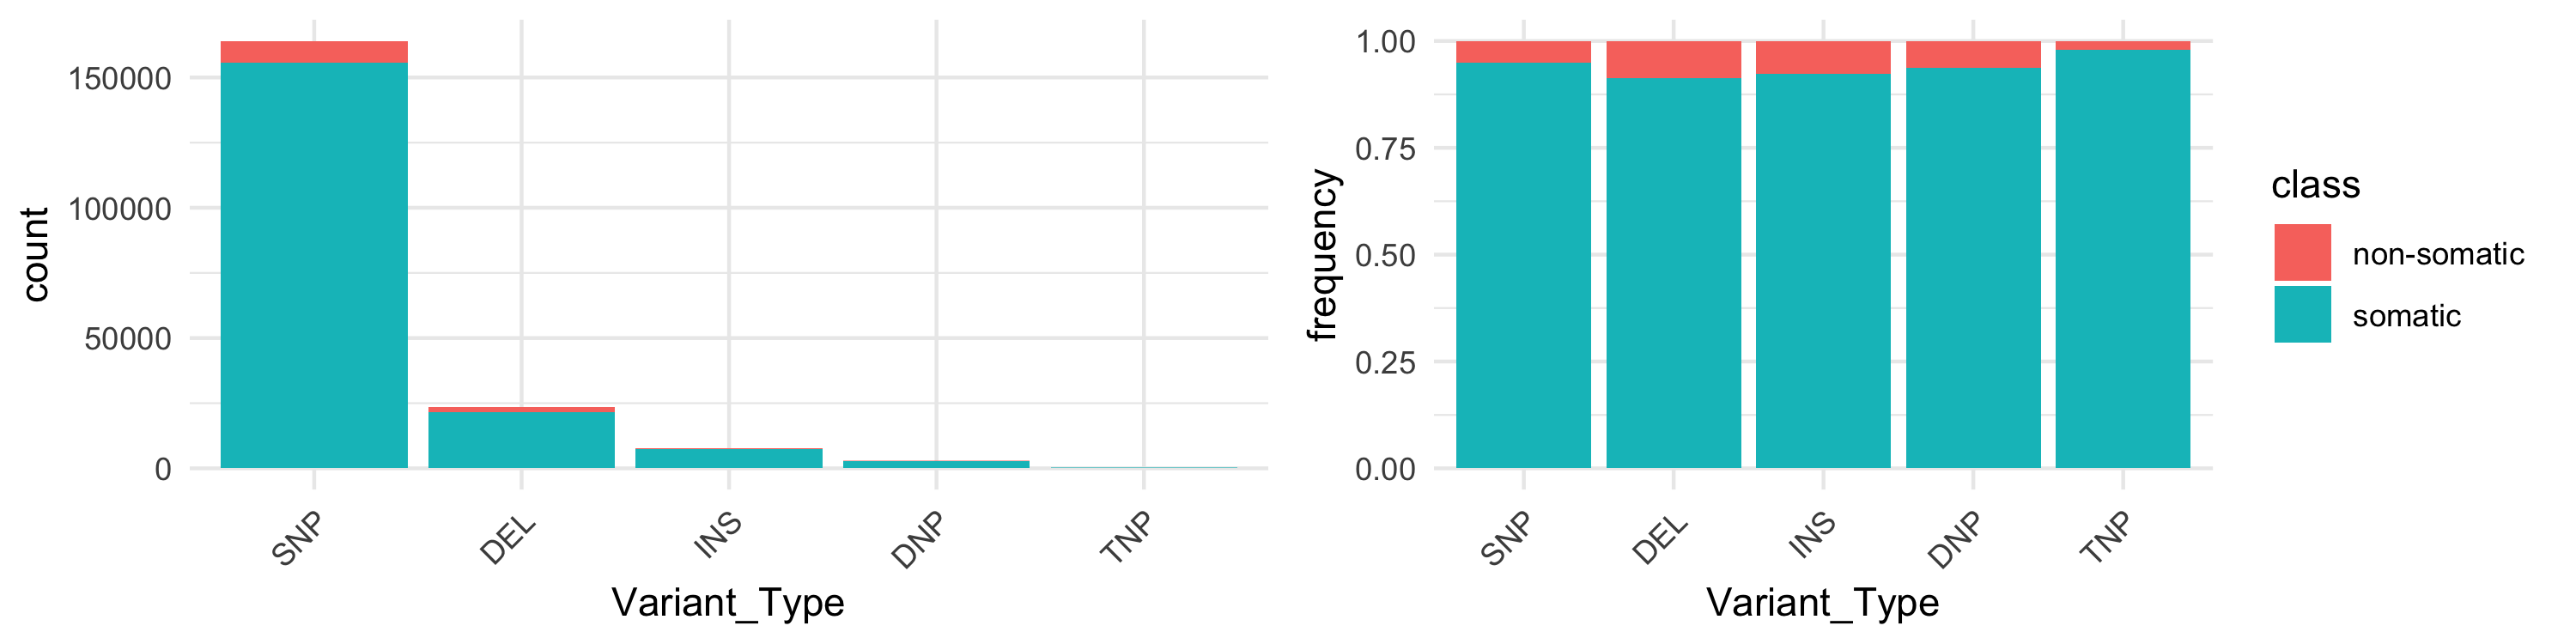

In [68]:
plot_contingency_table_as_histograms(impact, "Consequence", "class")
plot_contingency_table_as_histograms(impact, "Variant_Type", "class", 10, 2.5)

Nothing particularly interesting was found here, it does not seem the mutation `Consequence` or `Variant_Type` features have a clear impact on the `class` of the mutation. We can notice the relatively high amount of `non-somatic` in the `nonframeshift_deletion` and `nonframeshift_insertion` mutations.

### Comparison of the `frequency_in_normals`

Distribution of `frequency_in_normals` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

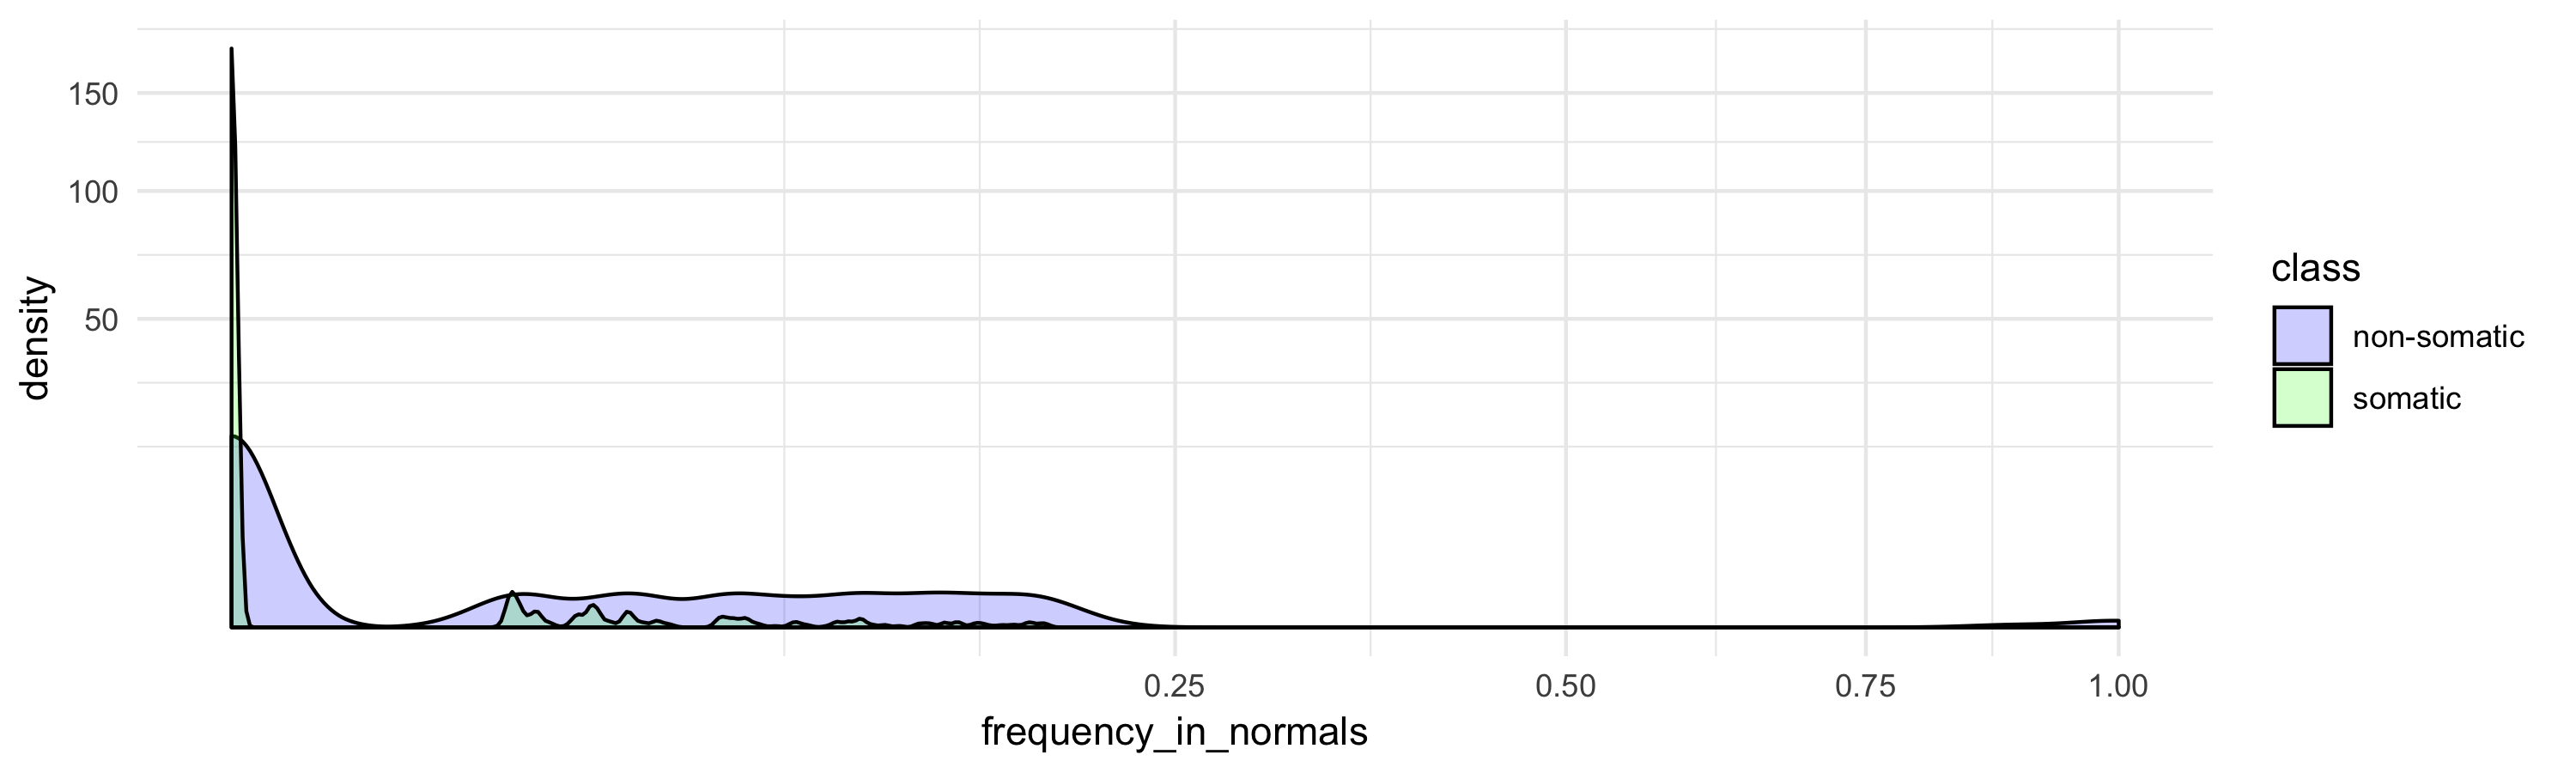

In [69]:
plot_density(impact, "frequency_in_normals", "class") + scale_x_sqrt() + scale_y_sqrt()

Overall the non-somatic mutations are, as expected, more present in normals (due to the germline part). However there are some somatic mutations with a not-so-close-to-0 `frequency_in_normals`:

[1] 2052

[1] 174

[1] 0

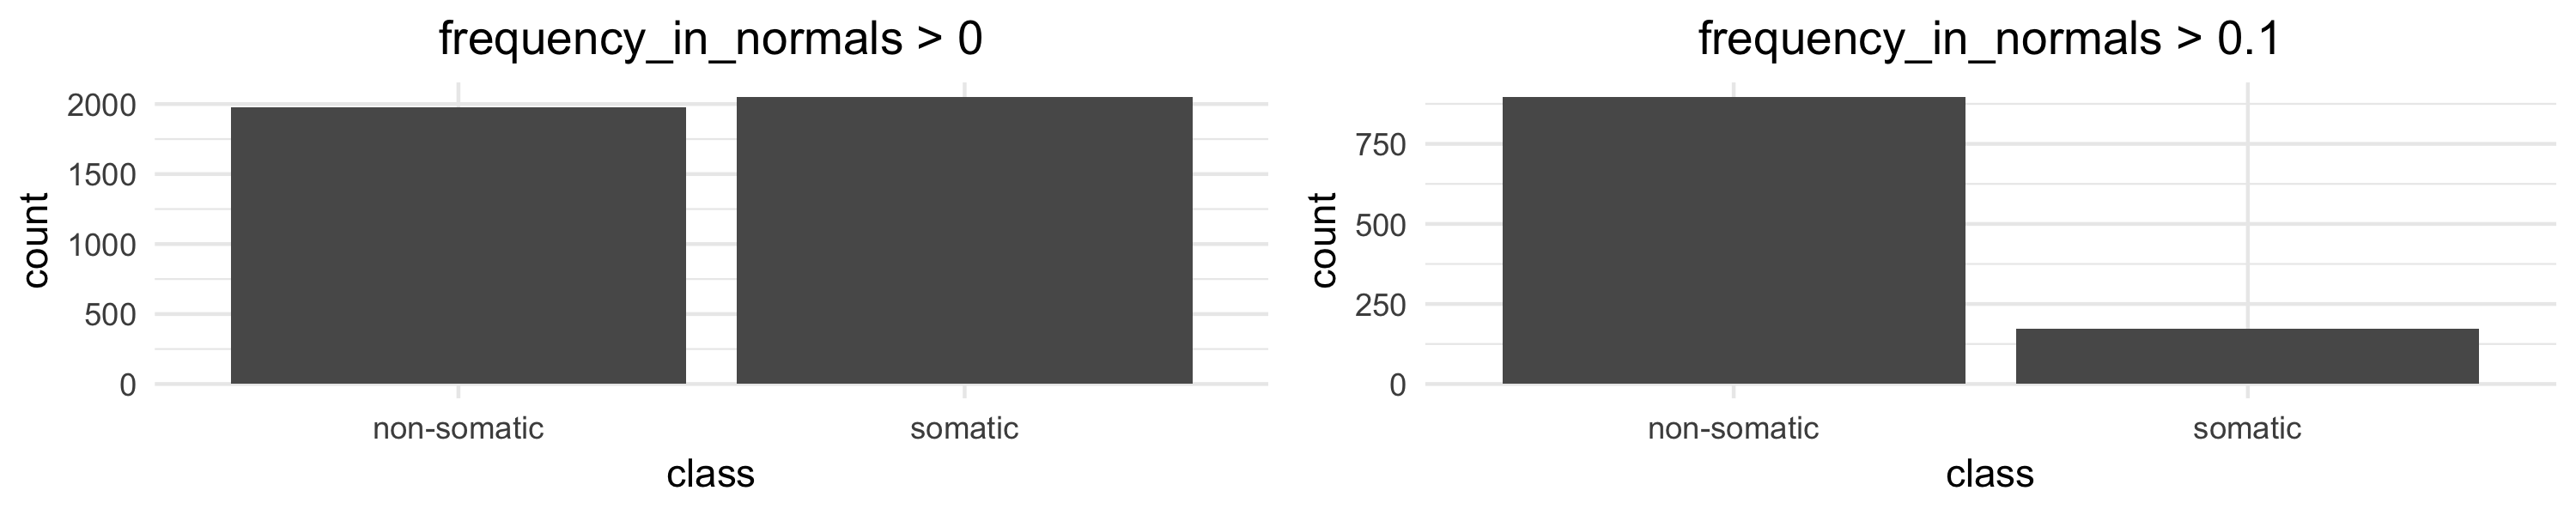

In [70]:
nrow(impact[impact$frequency_in_normals > 0   & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.2 & impact$class == "somatic",])

notebook_plot_size(6, 2)
plot1 <- ggplot(impact[impact$frequency_in_normals > 0  ,]) + geom_bar(aes(class)) + ggtitle("frequency_in_normals > 0"  ) + theme(plot.title = element_text(hjust = 0.5))
plot2 <- ggplot(impact[impact$frequency_in_normals > 0.1,]) + geom_bar(aes(class)) + ggtitle("frequency_in_normals > 0.1") + theme(plot.title = element_text(hjust = 0.5))
plot_side_by_side(plot1, plot2)

[1] "Number of different genes:  73"


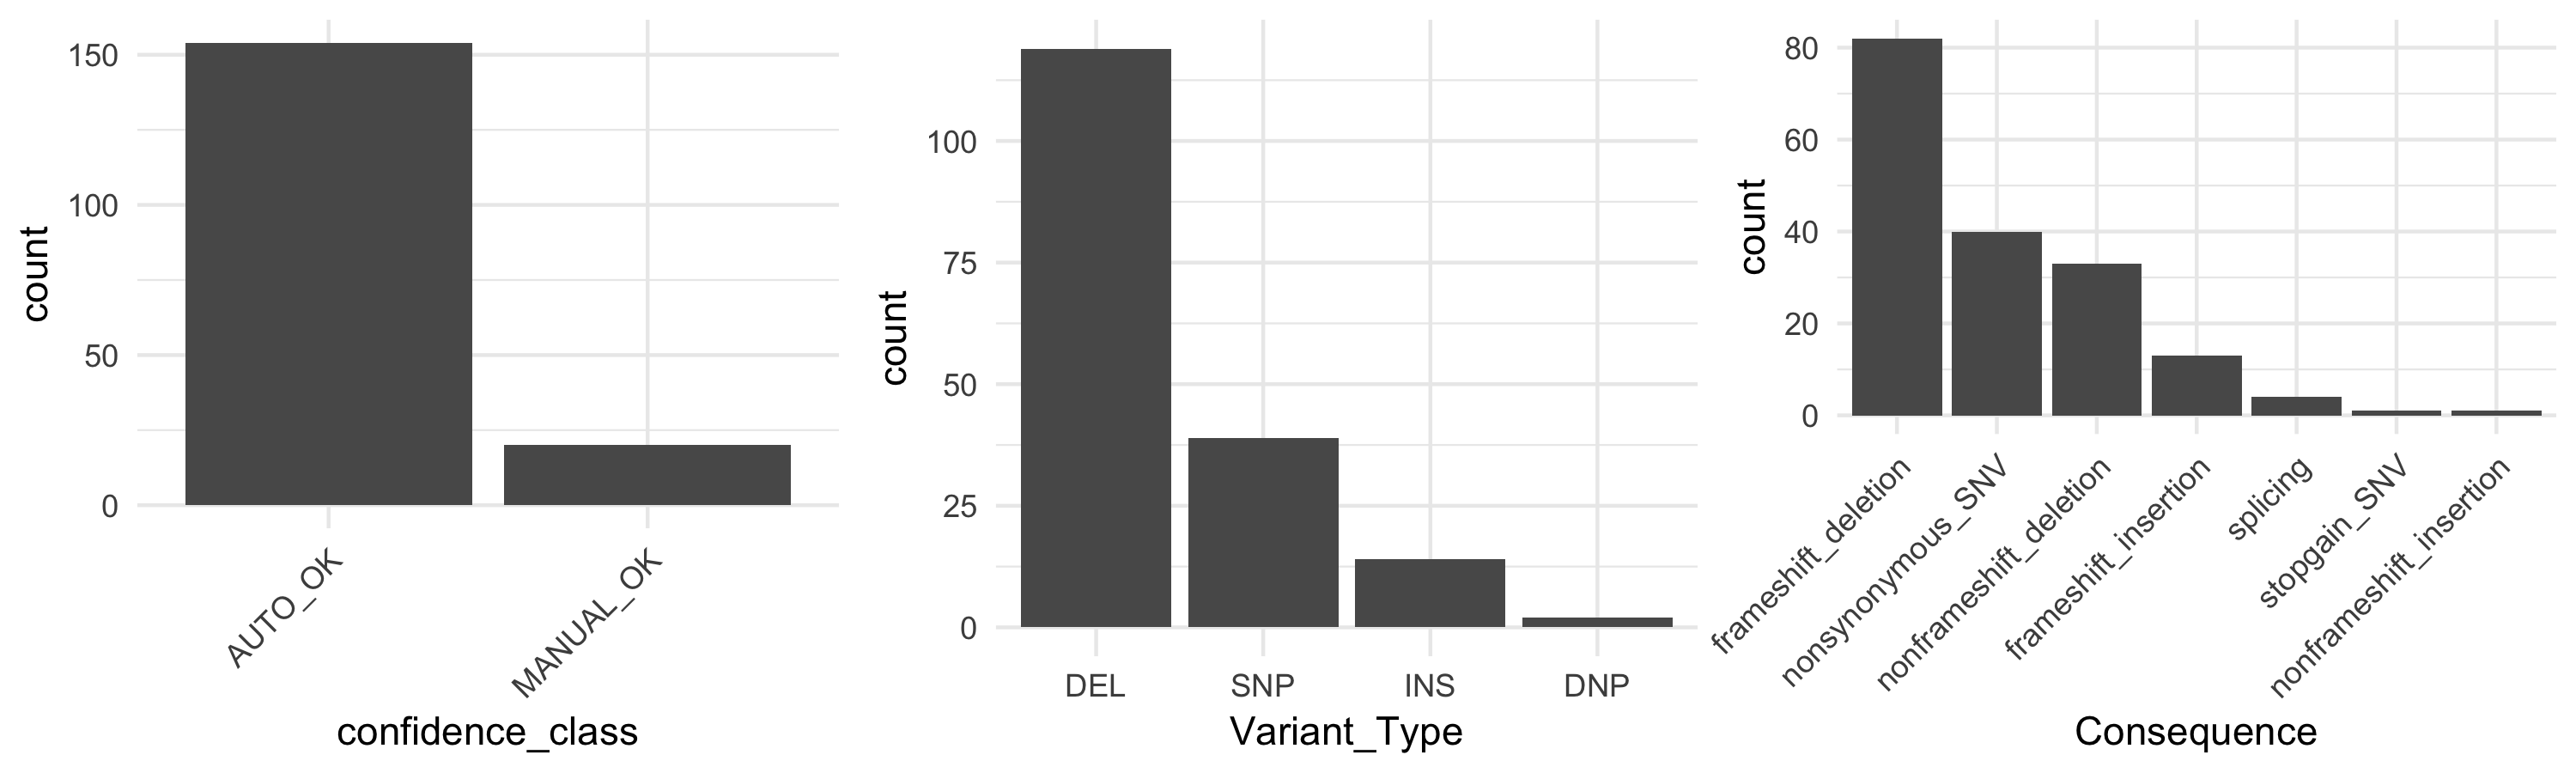

In [71]:
get_possible_correlations(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])

[1] "Number of different genes:  379"


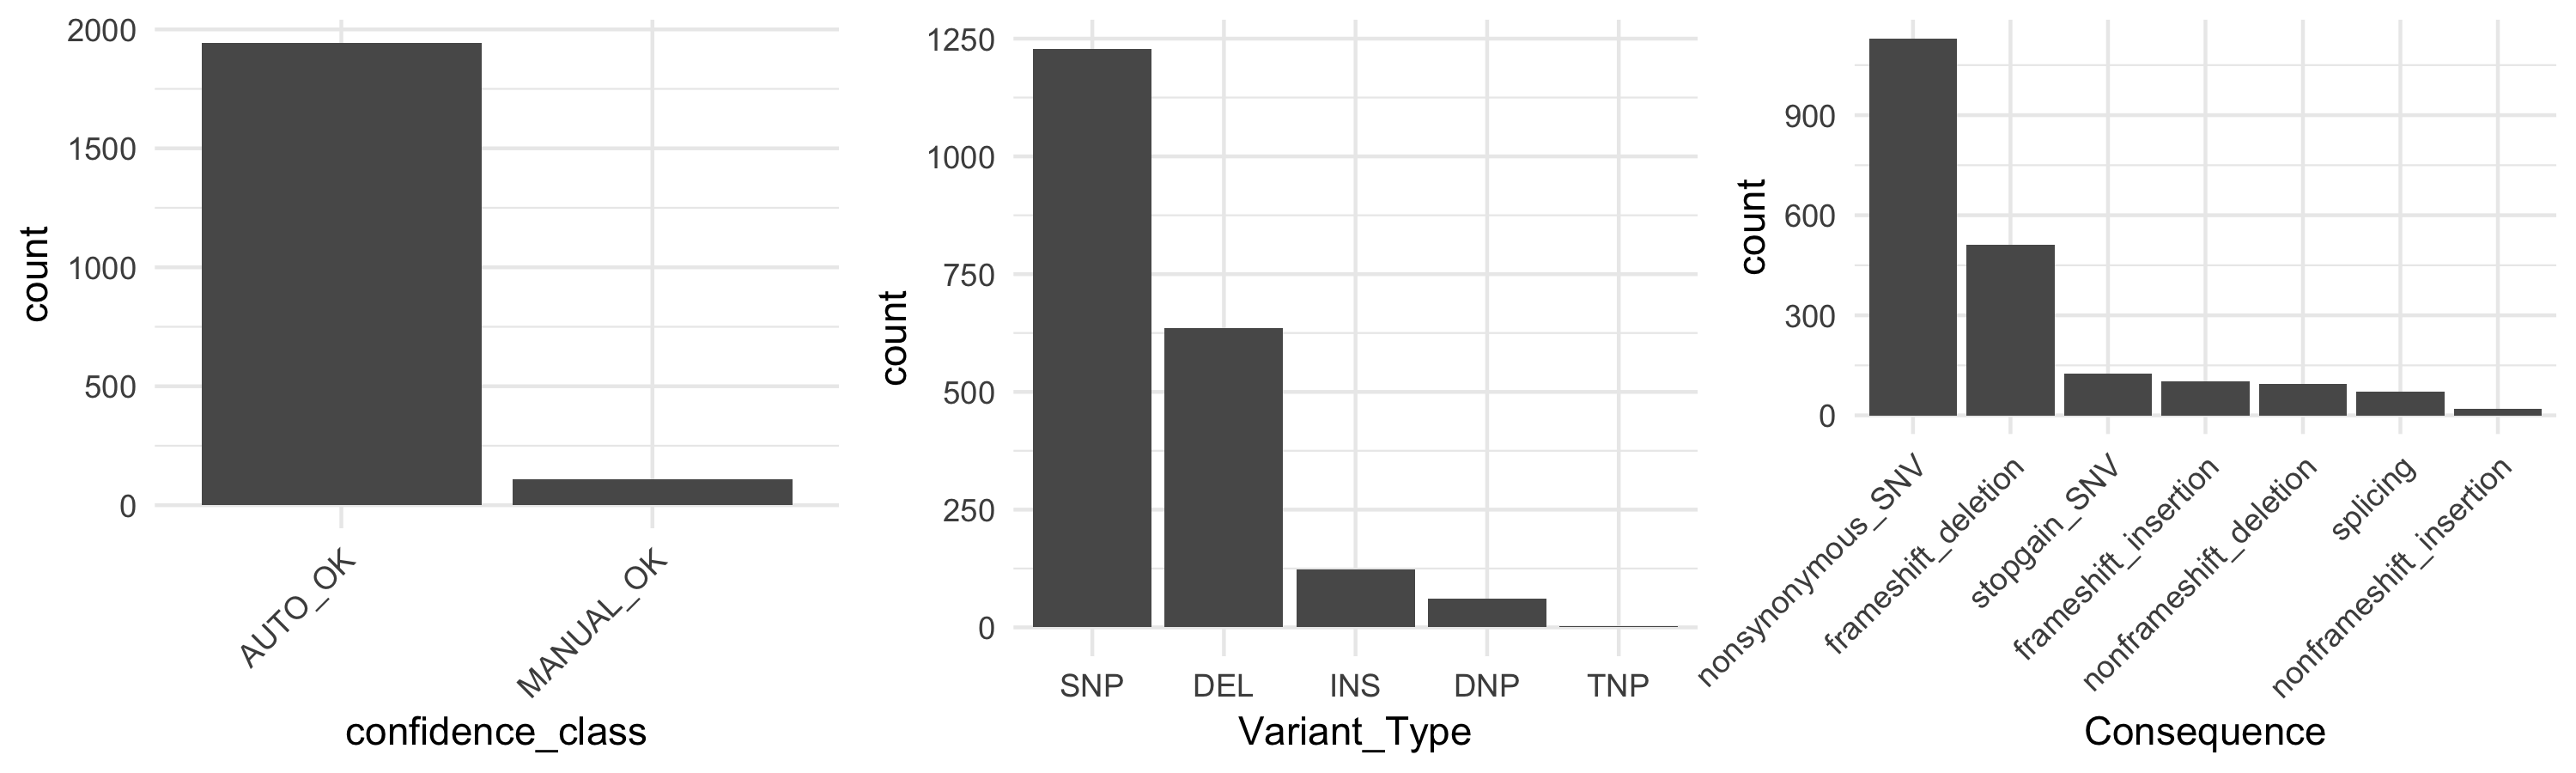

In [72]:
get_possible_correlations(impact[impact$frequency_in_normals > 0 & impact$class == "somatic",])

### Comparison of the `t_vaf`

Distribution of `t_vaf` for the somatic vs non-somatic `class`:

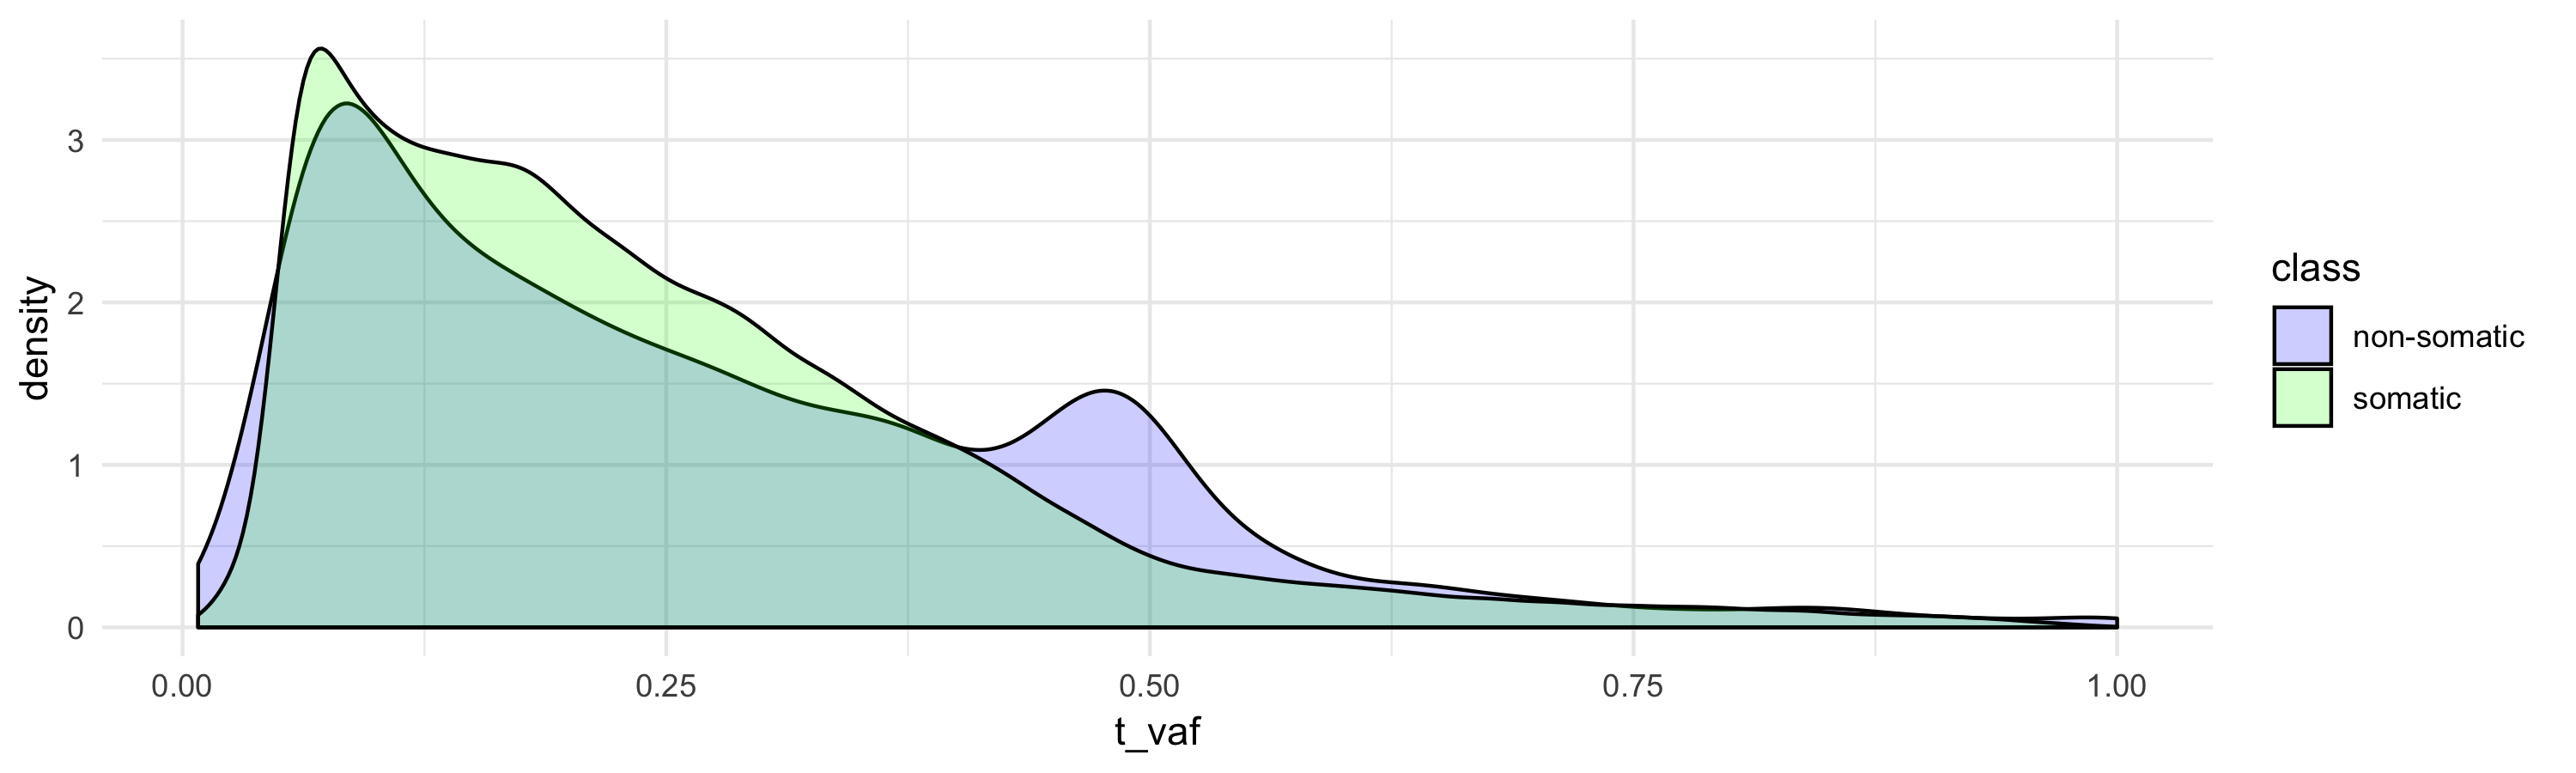

In [73]:
plot_density(impact, "t_vaf", "class")

From `CodingDistributions.Rmd [Elsa]`: "As expected, the non-somatic density has a peak at 0.5 (ie the likely germline calls), and a peak at low VAF (ie the likely artefacts calls)."

### Comparison of the strand bias

We evaluate the `strand_ratio` for each mutation as:
$$\text{strand_ratio}\ =\ \frac{\min(\text{t_alt_neg_count}, \text{t_alt_plus_count})}
                              {\max(\text{t_alt_neg_count}, \text{t_alt_plus_count})}$$
                              
e.g. the lowest count over the maximum count, thus giving a result between 0 and 1 (1 being a low strand bias, because the count for the neg and pos are the same).

In [74]:
impact$strand_ratio <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                       pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `strand_ratio` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

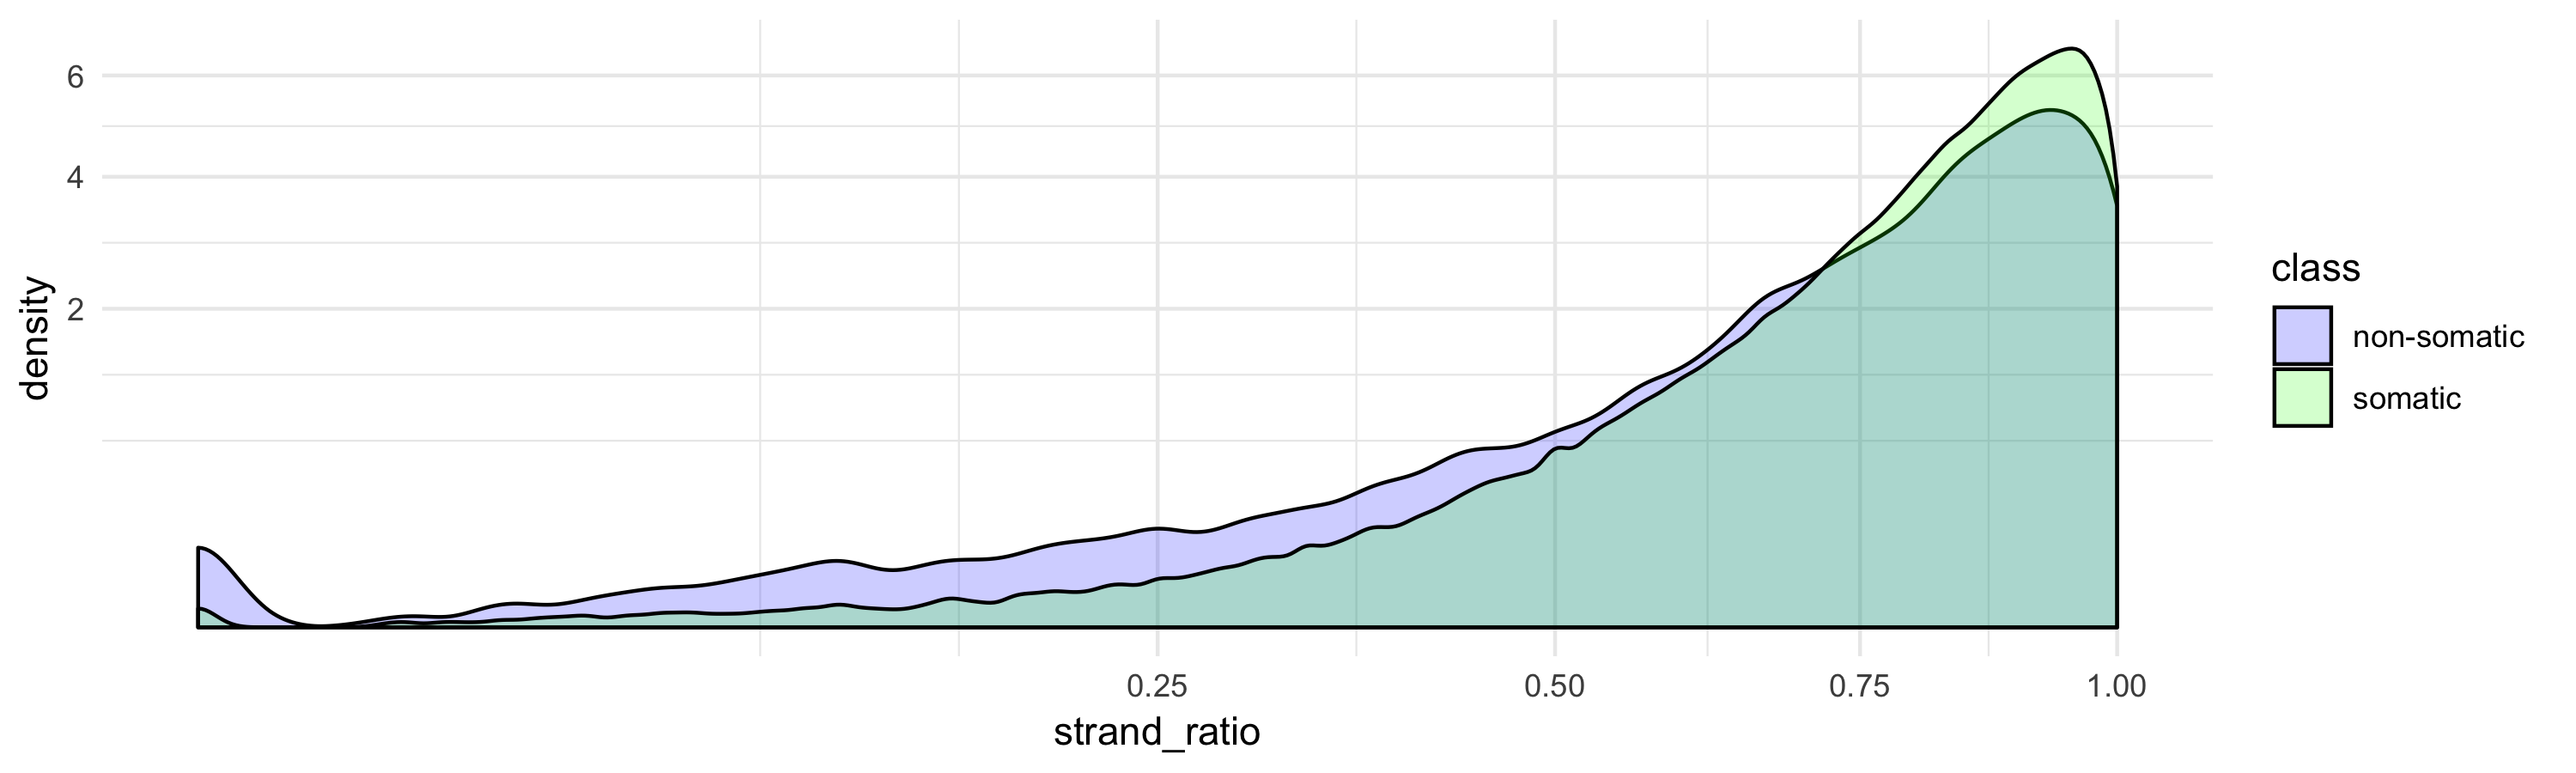

In [75]:
plot_density(impact, "strand_ratio", "class") + scale_x_sqrt() + scale_y_sqrt()

From `CodingDistributions.Rmd [Elsa]`: "As expected, the non-somatic density has a heavier low strand ratio tail (likely from the artefact calls), although this is not very pronounced."

### `strand_ratio` vs `t_vaf`

Below is an attempt to plot the `strand_ratio` vs the `t_vaf` to separate the germline (`t_vaf` $\approx 0.5$ and high `strand_ratio`) from the artefact (low `t_vaf` and low `strand_ratio`):

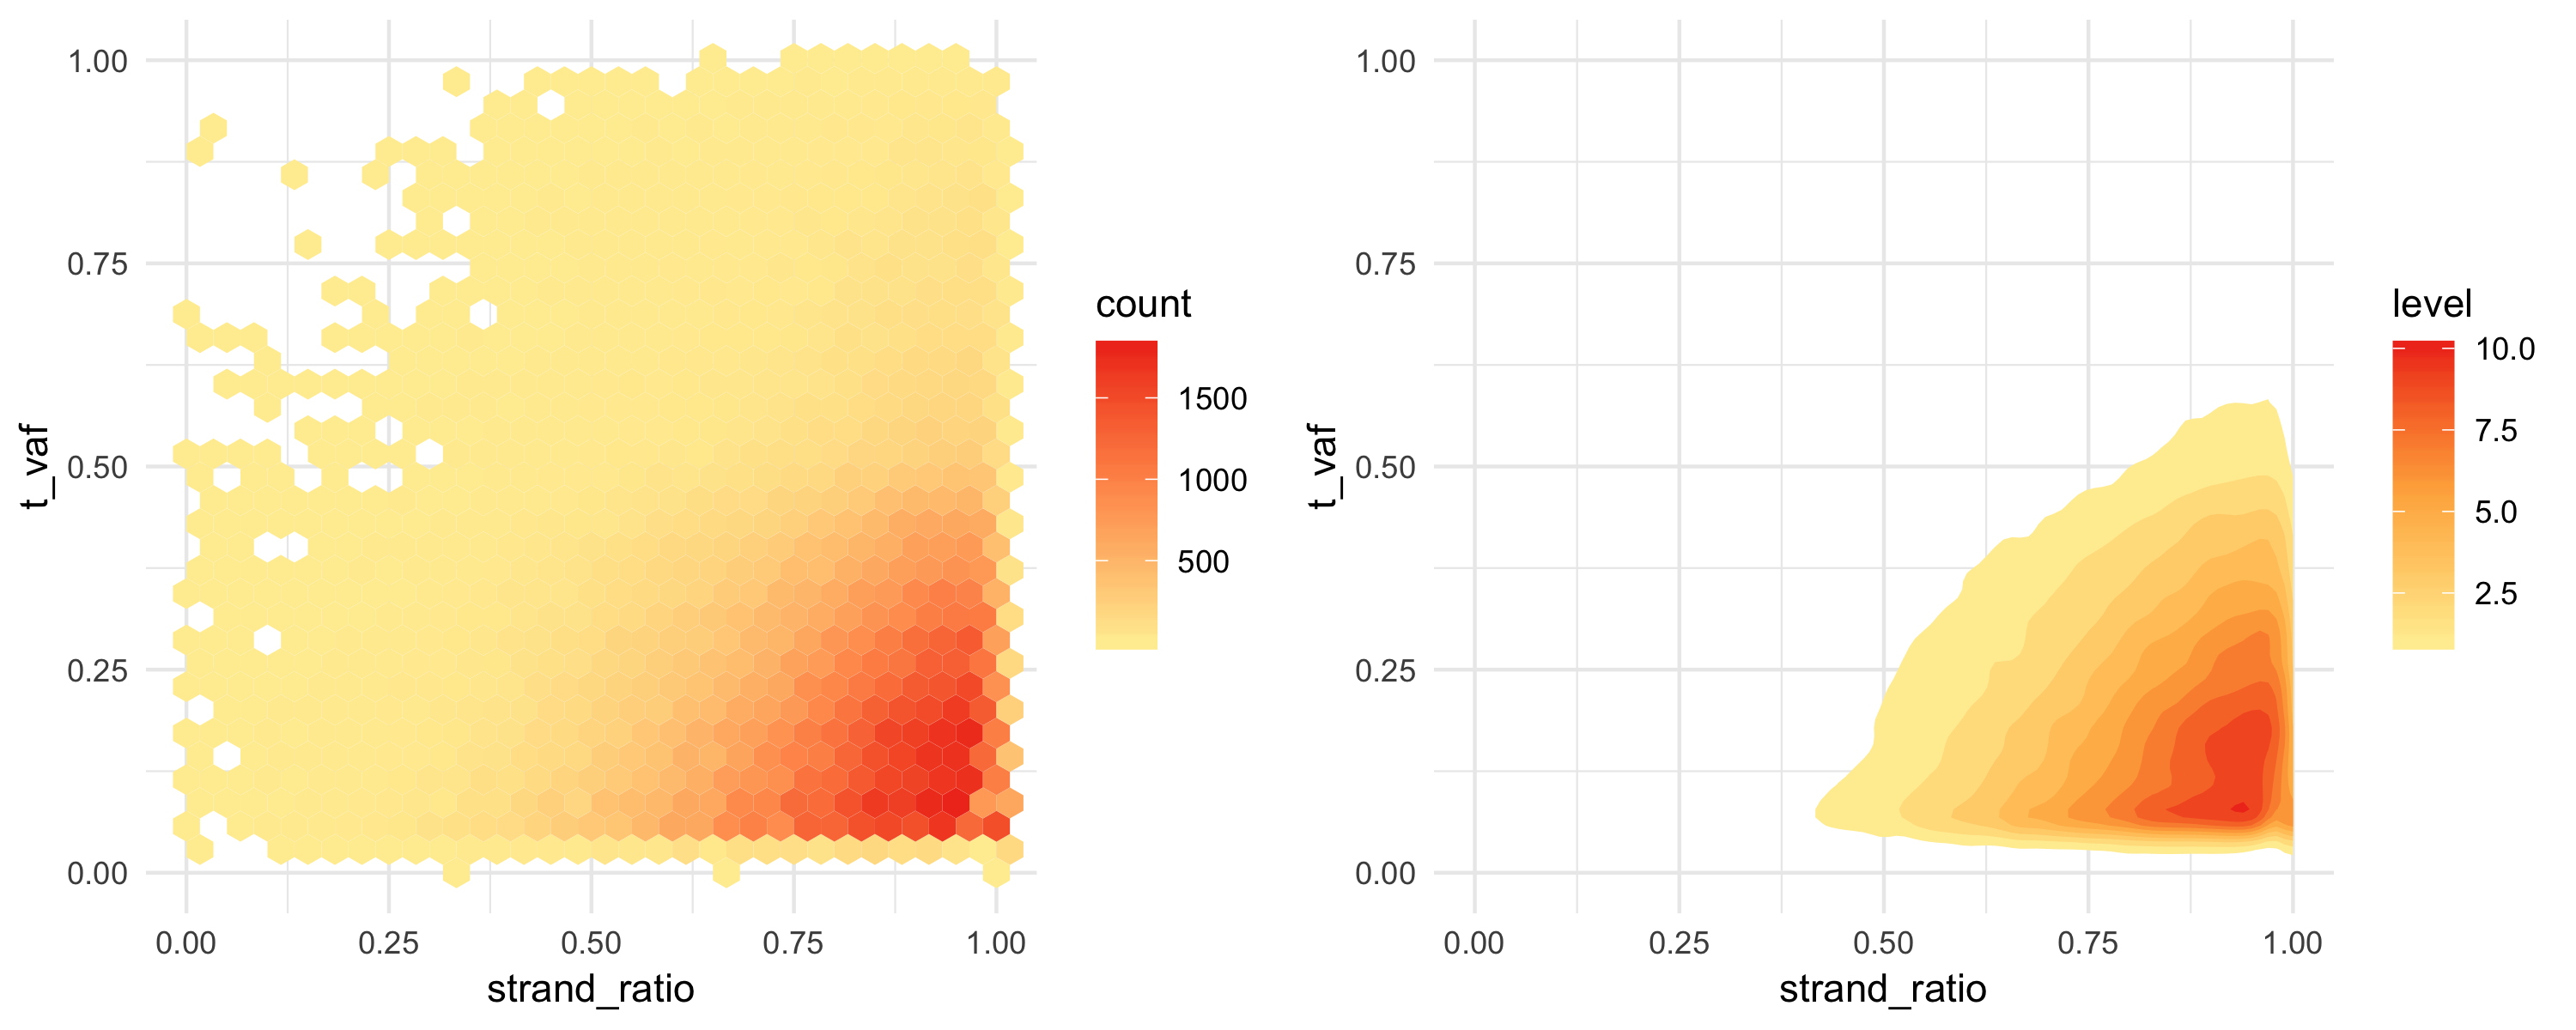

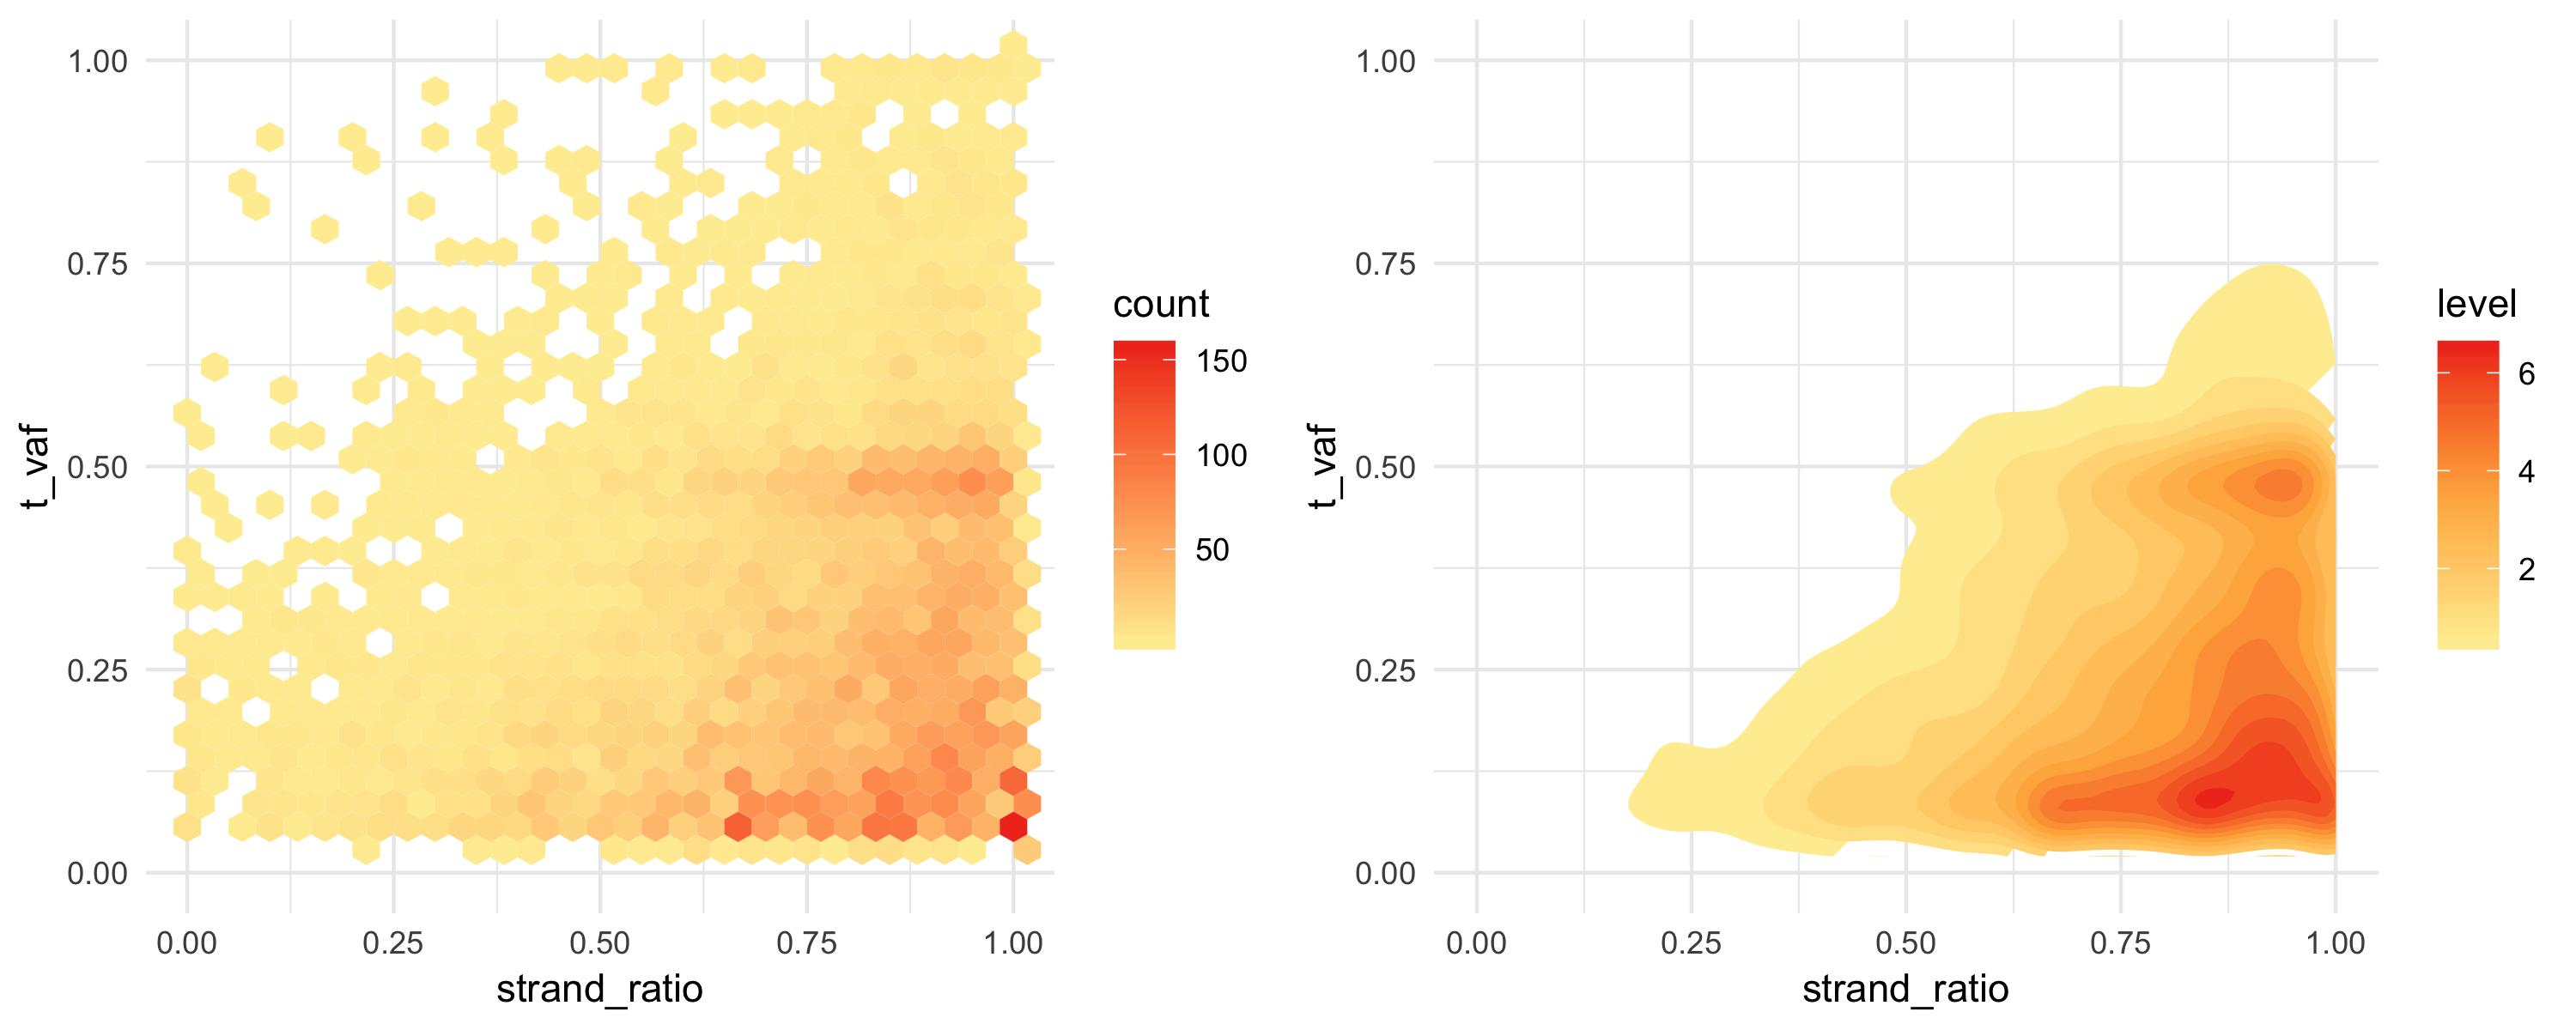

In [111]:
plot_density_2d(impact[impact$class == "somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))
plot_density_2d(impact[impact$class == "non-somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))

We clearly see the domain of the germline with a peak at `t_vaf = 0.5` in the lower right graph.

### Comparison of `Kaviar_AF`

Distribution of `Kaviar_AF` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

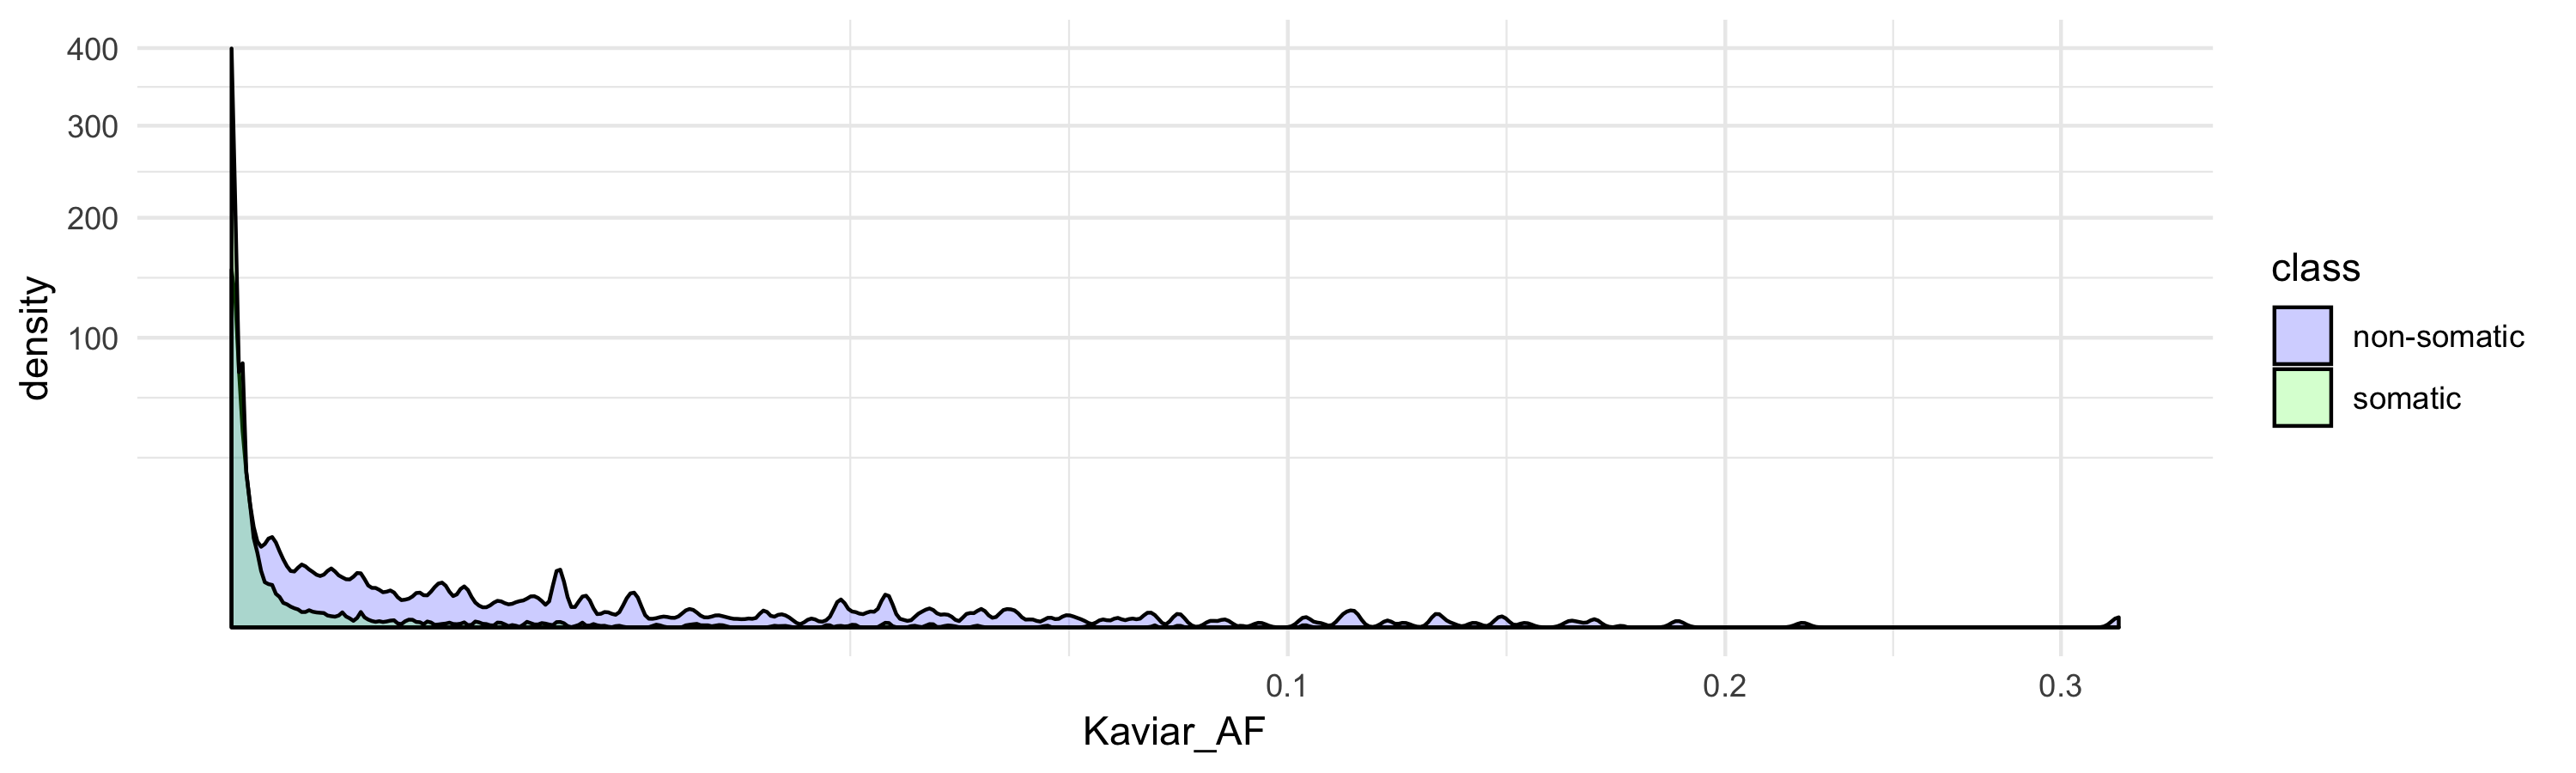

In [47]:
plot_density(impact, "Kaviar_AF", "class") + scale_x_sqrt() + scale_y_sqrt()

What was expected appears clearly, the `non-somatic` class presents a way longer tail on the higher `Kaviar_AF` value (due to the germline calls).

In [48]:
summary(impact$Kaviar_AF[impact$class == "somatic"])
summary(impact$Kaviar_AF[impact$class == "non-somatic"])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.000026 0.000000 0.172999 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0028339 0.0001423 0.3192330 

### Comparison of `cosmic_count`

In [49]:
summary(impact$cosmic_count[impact$class == "somatic"])
summary(impact$cosmic_count[impact$class == "non-somatic"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   223.1     1.0 20034.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0    77.7     0.0 33328.0 

Distribution of `cosmic_count` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

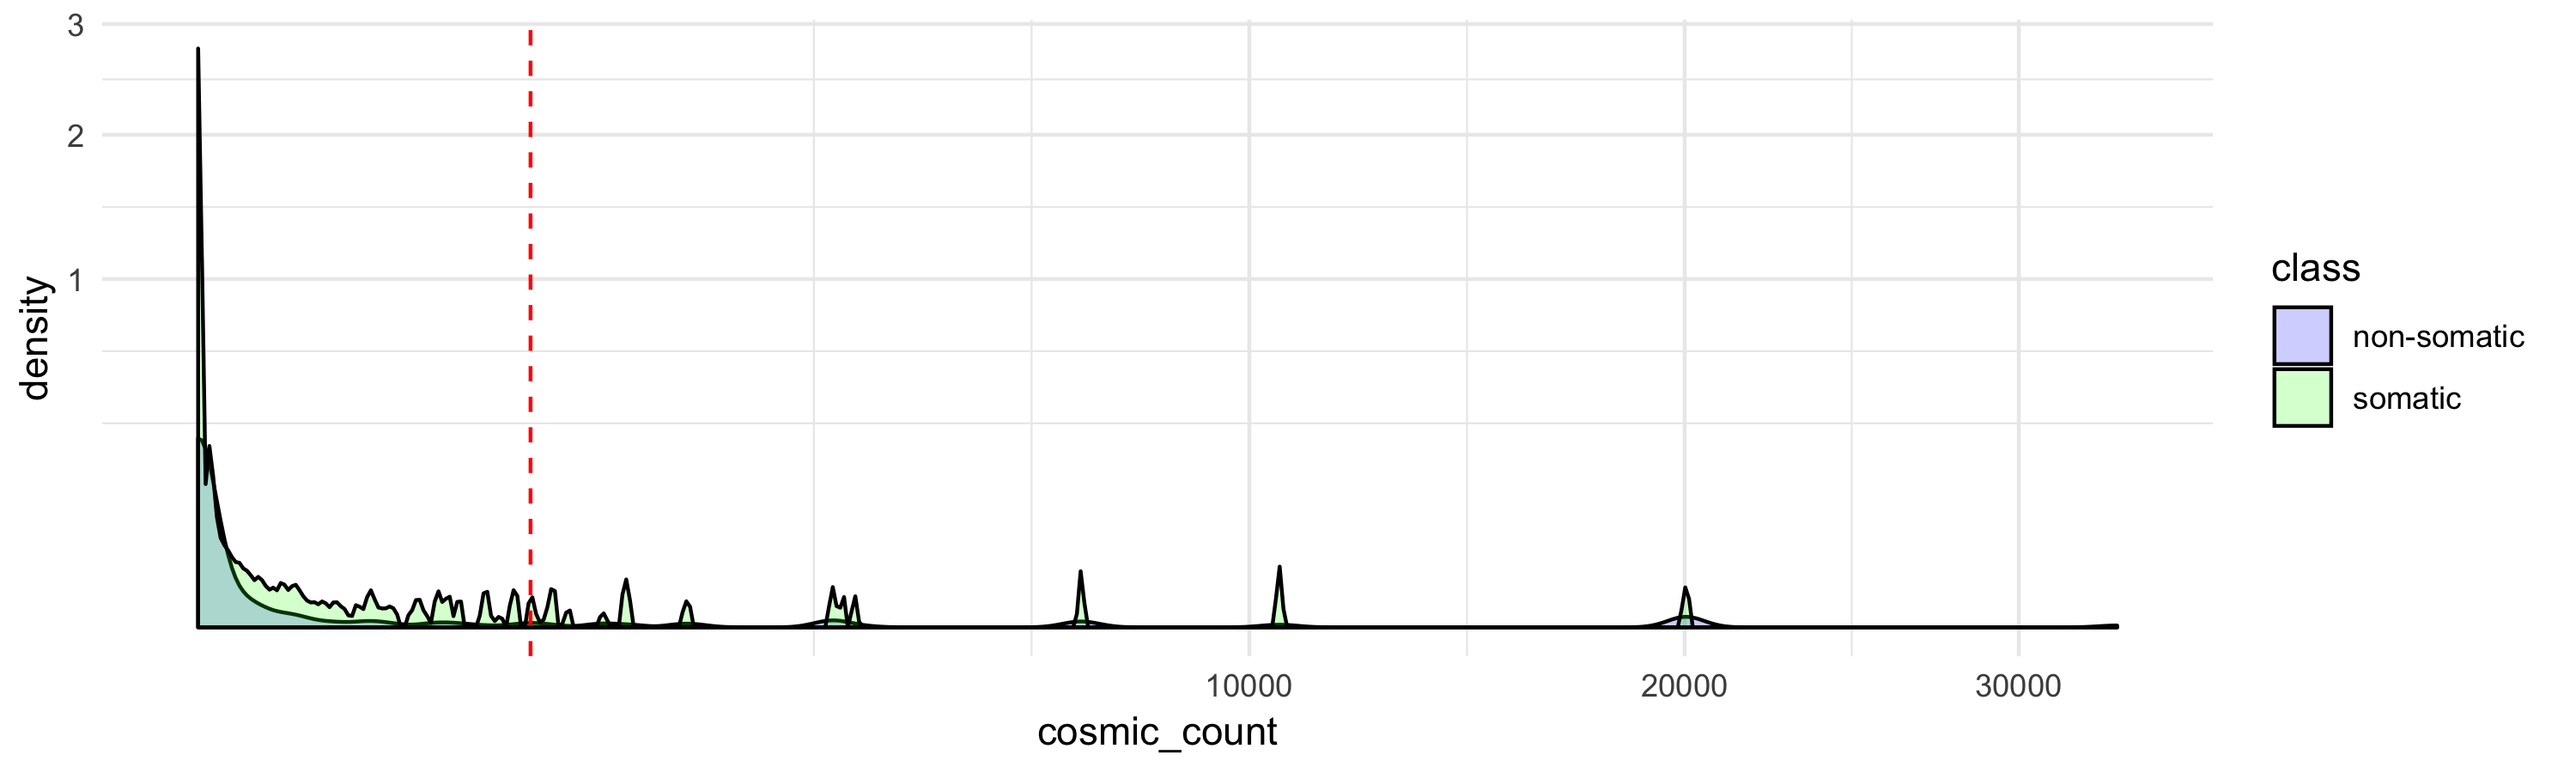

In [50]:
plot_density(impact, "cosmic_count", "class", lines = 1000) + scale_x_sqrt() + scale_y_sqrt()

We observe here that the mutations with a high `cosmic_count` are mostly classified as somatic, even if some have been curated as non_somatic.

In [51]:
unique(impact %>% filter(cosmic_count >= 1000) %>%
       group_by(mut_key) %>%
       mutate(n_somatic = sum(class == "somatic"), n_non_somatic = sum(class == "non-somatic")) %>%
       select(cosmic_count, mut_key, Hugo_Symbol, HGVSp_Short, Variant_Type, Consequence, n_somatic, n_non_somatic) %>%
       arrange(-cosmic_count))

cosmic_count,mut_key,Hugo_Symbol,HGVSp_Short,Variant_Type,Consequence,n_somatic,n_non_somatic
33328,9_5073770_G_T,JAK2,p.V617F,SNP,nonsynonymous_SNV,0,1
20034,7_140453136_A_T,BRAF,p.V600E,SNP,nonsynonymous_SNV,622,32
10579,12_25398284_C_T,KRAS,p.G12D,SNP,nonsynonymous_SNV,1110,2
7055,12_25398284_C_A,KRAS,p.G12V,SNP,nonsynonymous_SNV,896,10
3901,12_25398281_C_T,KRAS,p.G13D,SNP,nonsynonymous_SNV,287,1
3761,2_209113112_C_T,IDH1,p.R132H,SNP,nonsynonymous_SNV,307,0
3645,12_25398285_C_A,KRAS,p.G12C,SNP,nonsynonymous_SNV,566,14
2162,7_55259515_T_G,EGFR,p.L858R,SNP,nonsynonymous_SNV,305,4
1677,12_25398284_C_G,KRAS,p.G12A,SNP,nonsynonymous_SNV,190,1
1651,3_178952085_A_G,PIK3CA,p.H1047R,SNP,nonsynonymous_SNV,751,1


## The `mut_key` feature: study of reccurent mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [52]:
head(impact$mut_key)
length(unique(impact$mut_key)) # number of different keys e.g. number of different mutations

[1] "17_7577515_T_G"  "1_46521514_G_C"  "3_142178126_C_A" "4_55139732_T_A" 
[5] "4_153249542_C_A" "4_153332775_C_A"

[1] 135028

### Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [53]:
# create a patient id (no problem will be caused by 'None-T01-IM6' which will become 'None-T01-')
impact$patient_id <- substr(impact$Tumor_Sample_Barcode, 1, 9)
head(unique(impact$patient_id))

[1] "P-0000012" "P-0000023" "P-0000024" "P-0000025" "P-0000026" "P-0000030"

In [54]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact %>% group_by(patient_id) %>%
                                                               select(patient_id, mut_key, Hugo_Symbol, Consequence, Variant_Type, class) %>%
                                                               filter(! duplicated(mut_key)))
nrow(impact)
nrow(impact_unique_mut_keys_per_patient)

[1] 198311

[1] 190574

In [55]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(count = n(), Hugo_Symbol = unique(Hugo_Symbol)))
head(mut_key_info)

mut_key,count,Hugo_Symbol
1_108206648_AGAAGTTG_GAAGTTGT,1,ARID1A
1_11167549_A_G,1,MTOR
1_11168271_G_A,1,MTOR
1_11168272_A_G,1,MTOR
1_11168304_G_A,1,MTOR
1_11168316_A_G,1,MTOR


In [56]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "13% (17597) of the keys are shared by at least  2 samples [38% (73143) of the rows concerned]"
[1] " 5% ( 6248) of the keys are shared by at least  3 samples [26% (50445) of the rows concerned]"
[1] " 2% ( 2229) of the keys are shared by at least  5 samples [20% (37252) of the rows concerned]"
[1] " 1% (  857) of the keys are shared by at least 10 samples [15% (28739) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples (warning this is a sqrt x and y scale):

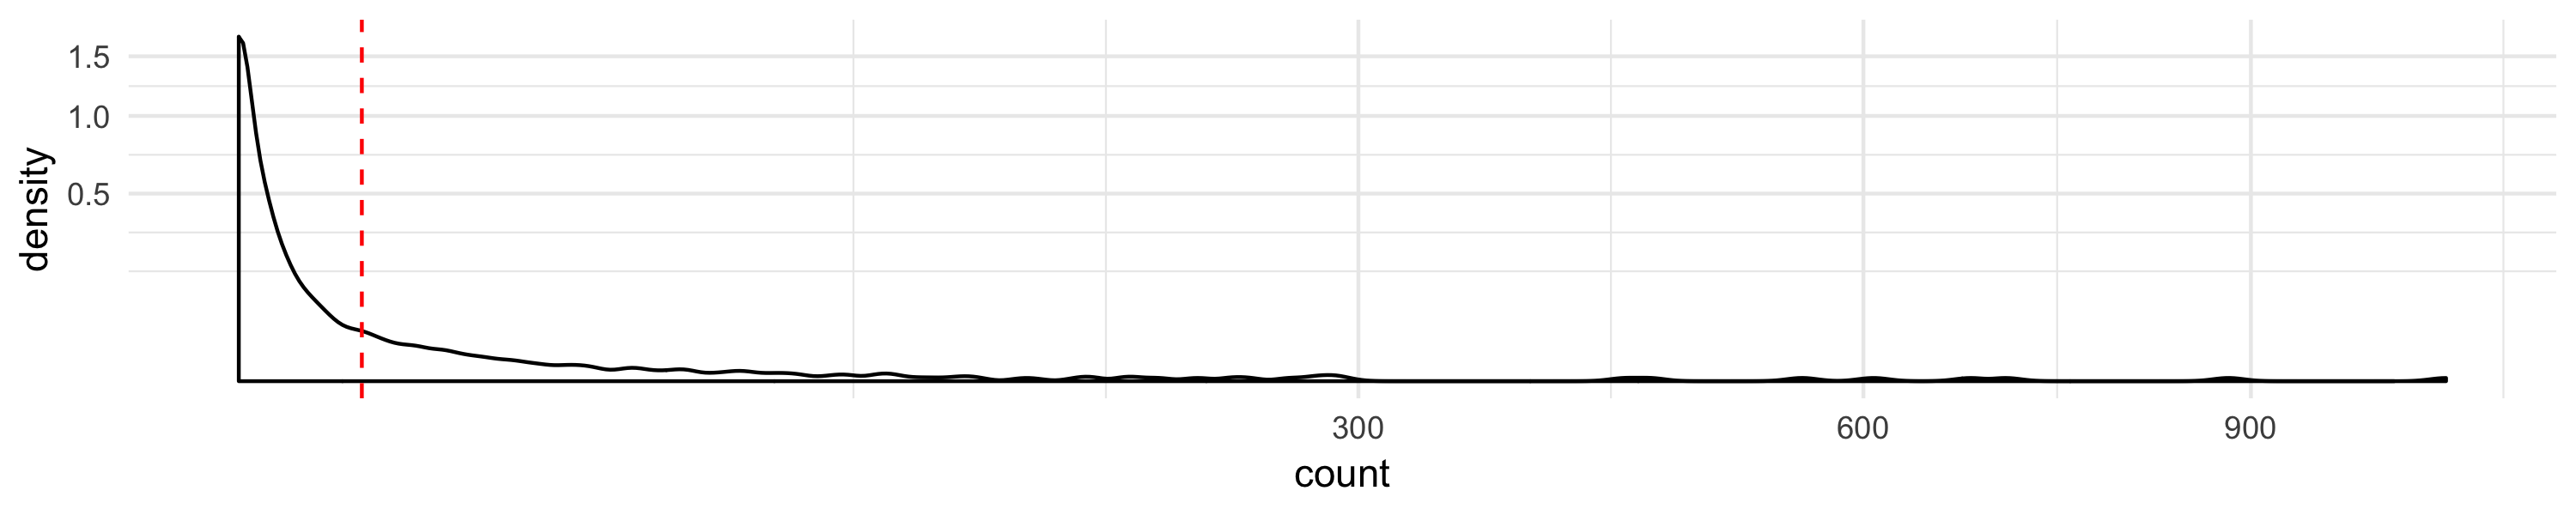

In [57]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
plot_density(repeated_key, "count", adjust = 5, lines = 10, height = 2) + scale_y_sqrt() + scale_x_sqrt()

### Sudy the reccurent mutations genes

In [58]:
length(unique(repeated_key$Hugo_Symbol))

[1] 463

In [59]:
head(repeated_key)

,mut_key,count,Hugo_Symbol
17,1_11169376_A_T,3,MTOR
18,1_11169377_T_A,3,MTOR
22,1_11169741_G_A,2,MTOR
28,1_11174379_C_T,2,MTOR
30,1_11174386_C_A,3,MTOR
31,1_11174395_A_C,4,MTOR


Here is a plot of the genes that are the most mutated **accross the mutation keys**:

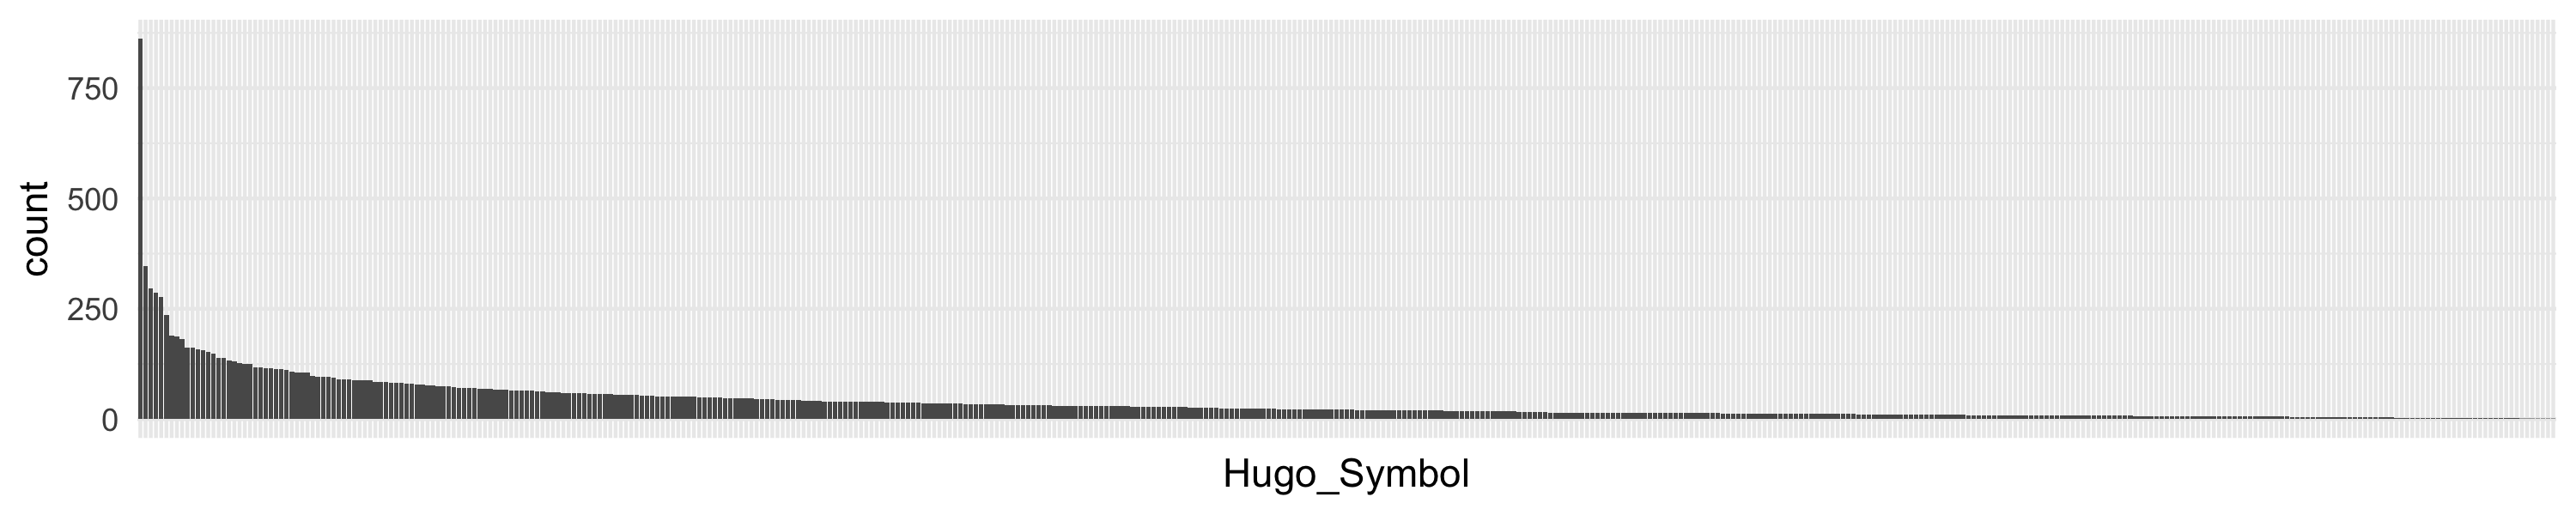

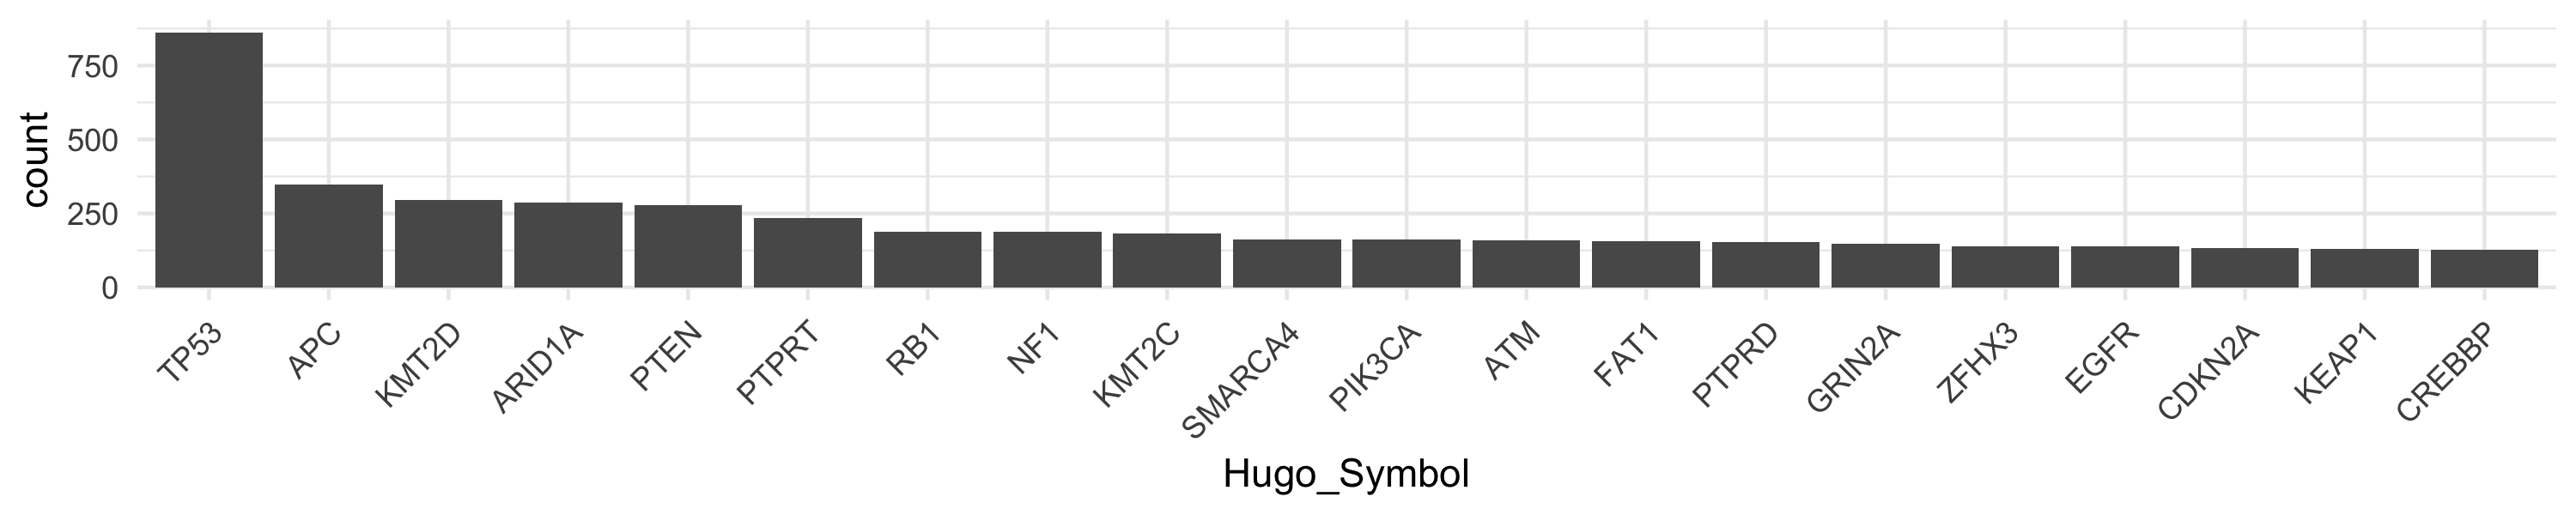

In [60]:
repeated_key <- sort_histogram(repeated_key, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

Here is a plot of the genes that are the most mutated **accross the rows**:

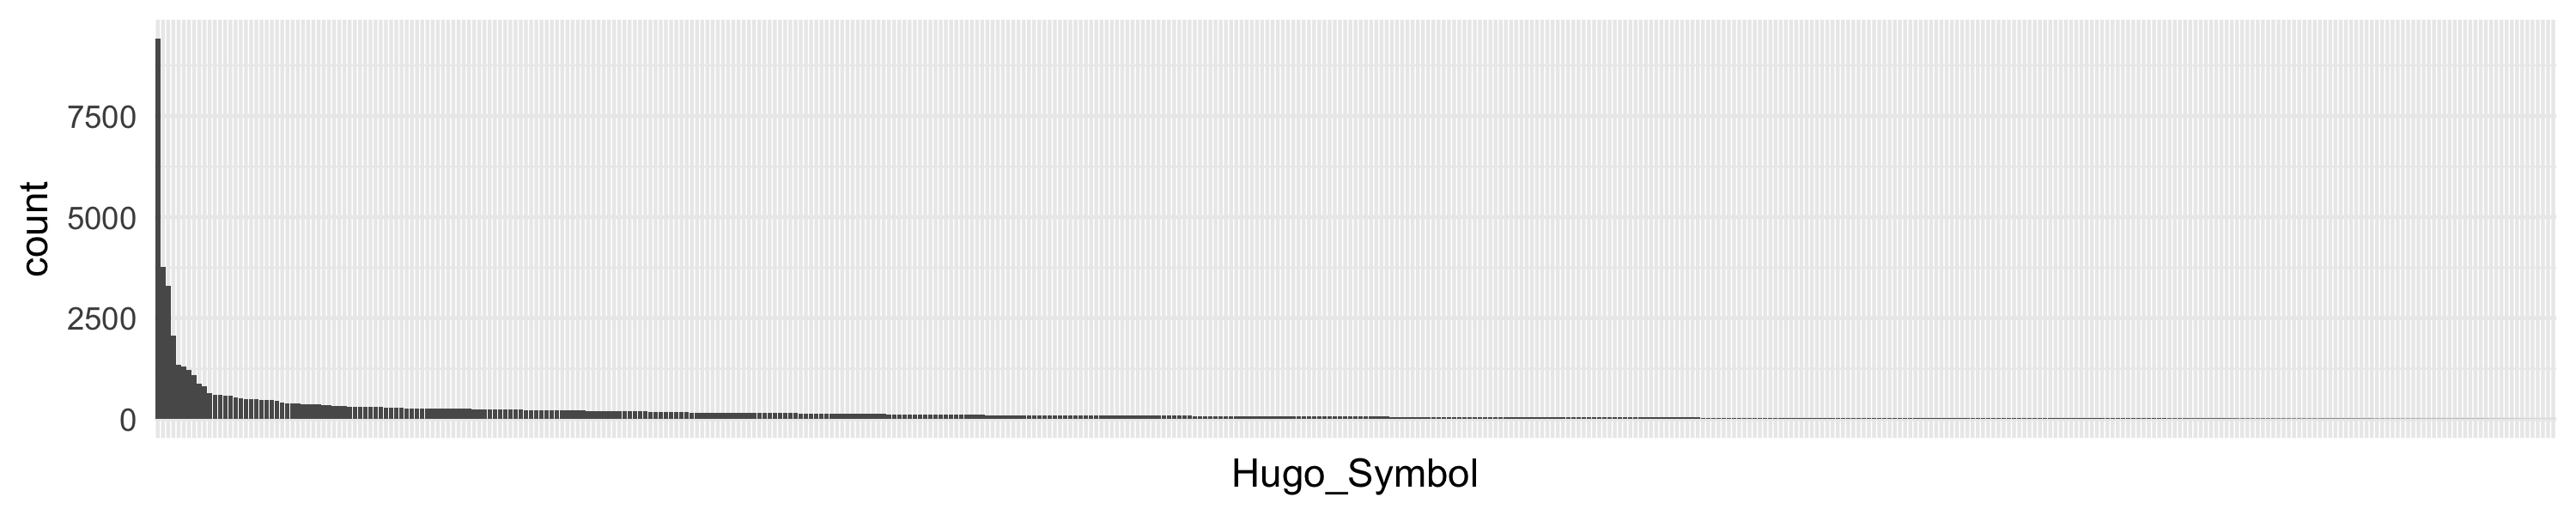

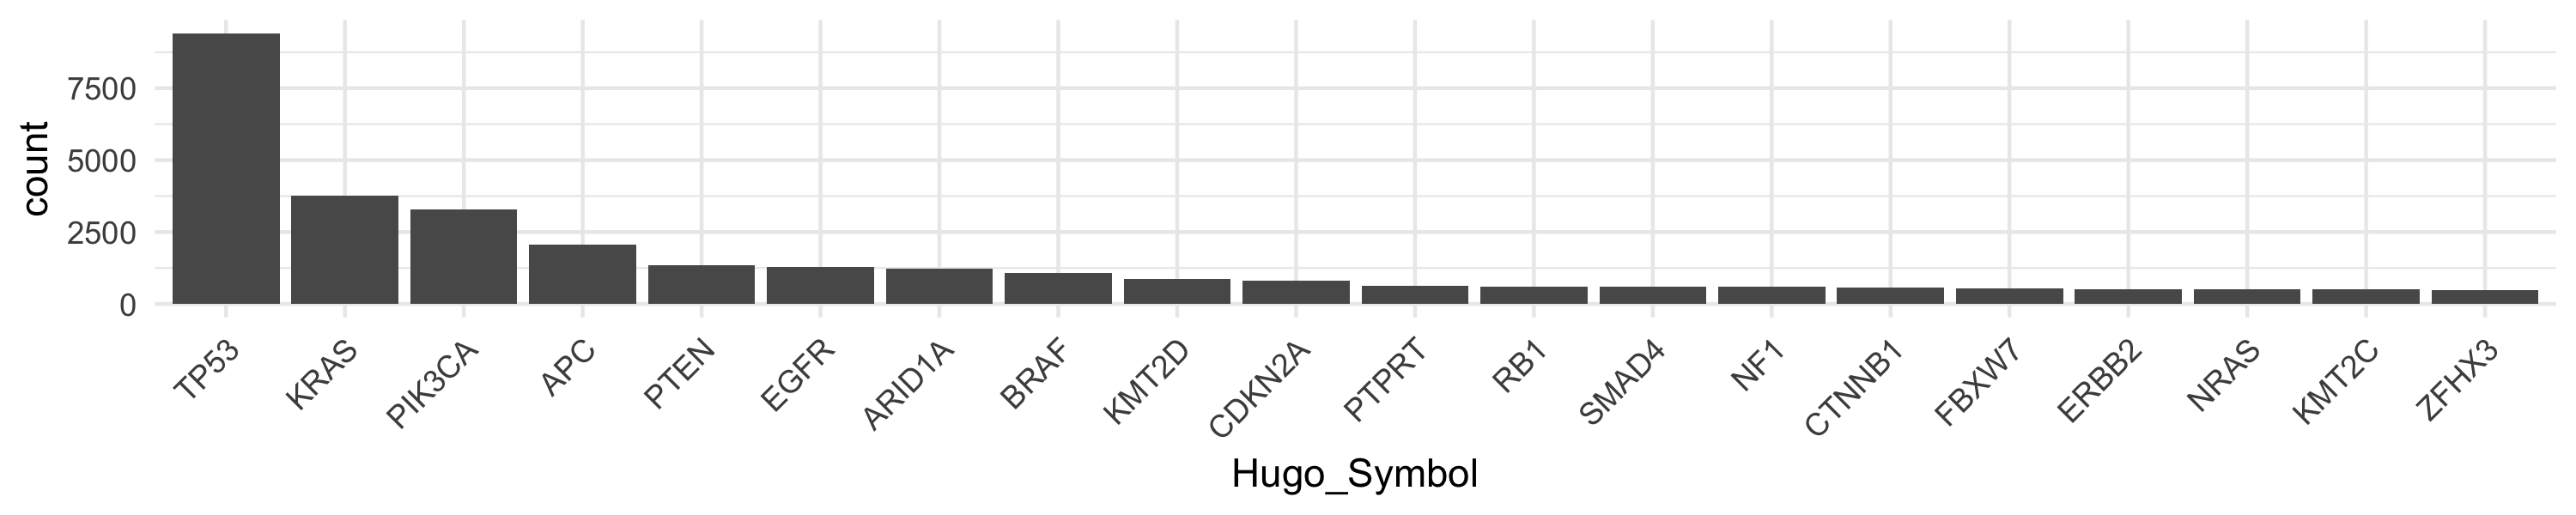

In [61]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Study of the proportion of inconsistent features

The mutations sharing the same key should have the same `class`, we evaluate the number of keys and mutations which have different `class` values (e.g the number of mutations classified as `somatic` once and `non-somatic` another time):

In [62]:
keys_inconsistent_class <- impact %>% filter(mut_key %in% repeated_key$mut_key) %>%
                                      group_by(mut_key) %>%
                                      summarise(n_class = length(unique(class)),
                                                n_somatic = sum(class == "somatic"),
                                                n_non_somatic = sum(class == "non-somatic"),
                                                prop_somatic = n_somatic / (n_somatic + n_non_somatic)) %>%
                                      filter(n_class > 1)

sprintf("%.2f%% (%d) keys with inconsistent class ie %.2f%% (%d) of the mutations",
        nrow(keys_inconsistent_class) / length(unique(impact$mut_key)) * 100,
        nrow(keys_inconsistent_class),
        nrow(impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]) / nrow(impact) * 100, 
        nrow(impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]))

[1] "1.07% (1440) keys with inconsistent class ie 9.21% (18257) of the mutations"

$10\%$ of the rows have a controversed class! Now we want to have an idea of the error: among the inconsistent labels is it always 50% somatic and 50% non-somatic, is it mostly somatic and sometimes non-somatic, another repartition? The plot below shows the repartition of the proportion of somatic among the inconsistent `keys`:

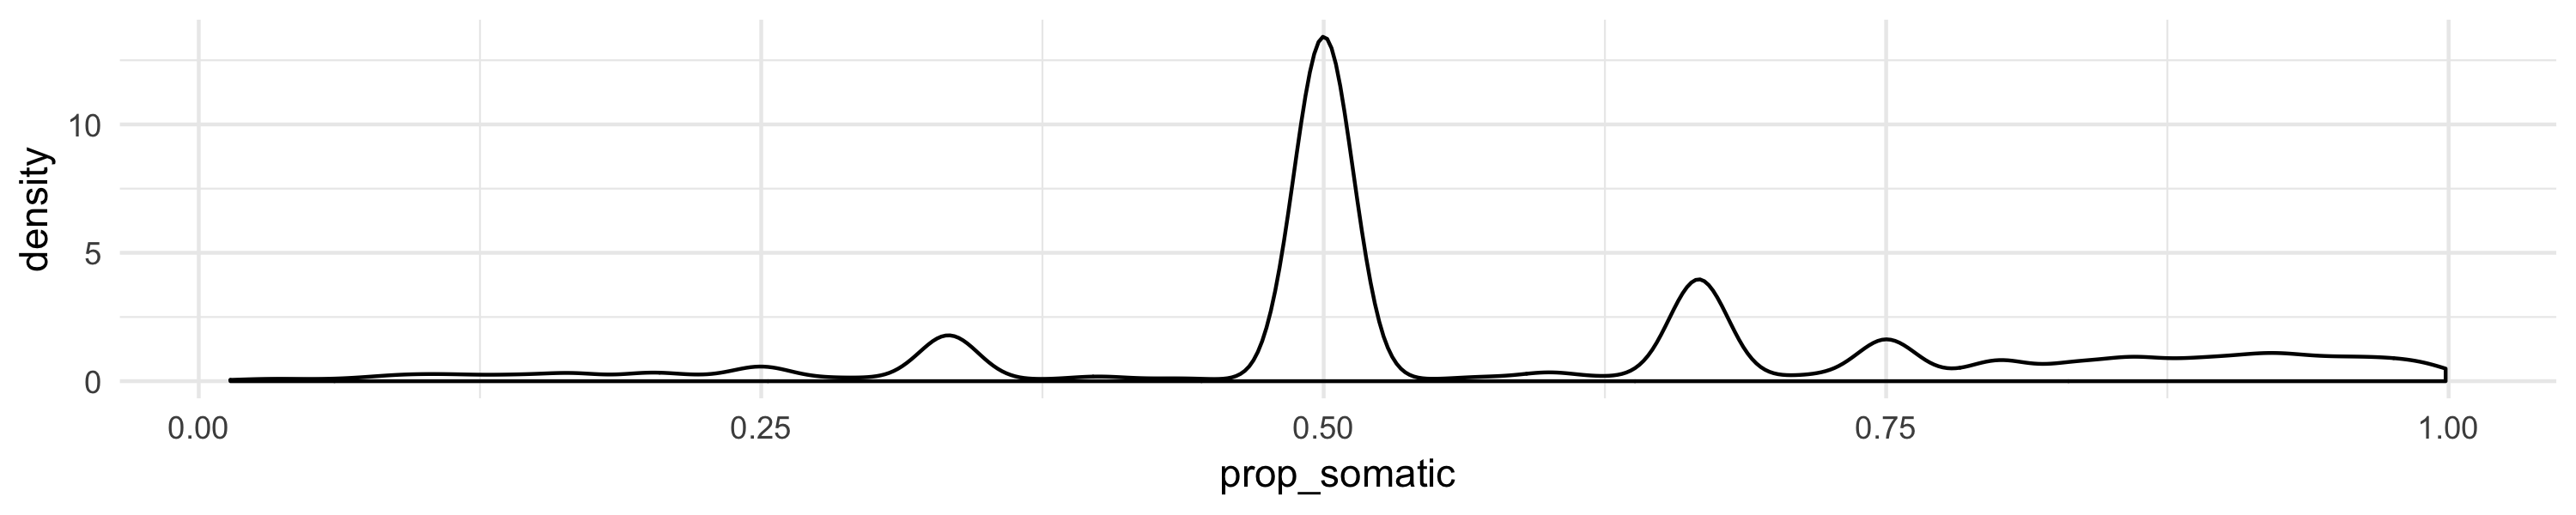

In [63]:
plot_density(keys_inconsistent_class, "prop_somatic", height = 2, adjust = 1/3)

So the errors are more uncertainity than real errors: in most cases, the mutation was equally classified as `somatic` than as `non-somatic`. The heavier tail on the `somatic` side is maybe due to the bigger proportion of `somatic` mutations in the dataset.